# GAN example

In [1]:
# import necessary packages

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
import sklearn

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose, UpSampling2D, Embedding, Concatenate


In [2]:
noise_dim = 100 

In [3]:
import cv2
import os
import numpy as np
def load_img(indir):
    samples = []
    labels = []
    for class_dir in os.listdir(indir):
        the_class = class_dir
        print("class",the_class)
        for file in os.listdir(indir+'/'+class_dir):
            #print(file)
            #print("{}/{}/{}".format(indir,class_dir,file))
            if file.endswith('ppm'):
                image = cv2.imread("{}/{}/{}".format(indir,class_dir,file))
                image = cv2.resize(image, (64,64))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                #image = np.expand_dims(image,axis=2)
                samples.append(image)
                labels.append(the_class)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples,labels

In [4]:
samples, labels = load_img('signs4')
print('loaded',len(samples),' samples')
print('classes',set(labels))
samples = samples/255

import sklearn.preprocessing
encoder = sklearn.preprocessing.LabelEncoder() # encoder
labels = encoder.fit_transform(labels)

class 00001
class 00007
class 00014
class 00016
loaded 3300  samples
classes {'00014', '00001', '00016', '00007'}


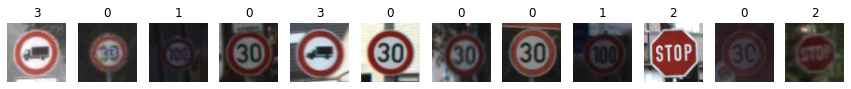

In [5]:
import random
plt.figure(figsize=(15, 15))
for i in range(12):
    ax = plt.subplot(1, 12, i + 1)
    r = random.randint(0,samples.shape[0])
    plt.imshow(samples[r][:,:])
    plt.title(labels[r])
    plt.axis("off")

In [6]:
# Generator gets a noise vector of size noise_dim and class to generate (one of 0,1,2,3) and generates an image of size (32 x 32 x 1)
# Our aim: we want the image to be as similar to real images (generated above) as possible
def make_generator_model():
    
    
    input_layer = tf.keras.layers.Input(shape=(noise_dim,))
    x = Dense(8*8*256, use_bias=False)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Reshape((8, 8, 256))(x)

    
    # second input - gets a class (vector of 4 values) 
    input_label = tf.keras.layers.Input(shape=(1,))
    # embedding from 4 values to 50
    y = Embedding(4, 50)(input_label)
    # scale up to 8*8 to fit the first input
    y = Dense(8*8)(y)
    y = Reshape((8, 8, 1))(y)
 
    # join both inputs
    merged = Concatenate()([x, y])
 
    
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False)(merged)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    # output: 8 x 8 x 128

    x = UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest")(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    # output: 16 x 16 x 64

#     x = UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest")(x)
#     output_layer = Conv2D(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid')(x)
#     # output: 32 x 32 x 1 (our image)

    x = UpSampling2D(size=(4, 4), data_format=None, interpolation="nearest")(x)
    output_layer = Conv2D(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid')(x)
    # output: 32 x 32 x 1 (our image)

    model = tf.keras.models.Model(inputs=[input_layer,input_label], outputs=output_layer)
    model.summary()
    return model



generator = make_generator_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16384)        1638400     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16384)        65536       dense[0][0]                      
______________________________________________________________________________________________

In [7]:
# Discriminator gets image of size (32 x 32 x 1) and class (one of 0,1,2,3) and decides if the image is real or fake
def make_discriminator_model():
    
    
    # input 1 - one number, class id (0,1,2,3)
    input_label = tf.keras.layers.Input(shape=(1,))
    # embedding from 4 values to 50
    y = Embedding(4, 50)(input_label)
    # scale up to image dimensions with linear activation
    #y = Dense(32*32)(y)
    y = Dense(64*64)(y)
    y = Reshape((64, 64, 1))(y)
 
    
    # input 2 - the image
    input_layer = tf.keras.layers.Input(shape=(64, 64, 3))
    
    # image (32x32x1) is concatenated with the class (encoded as 32x32x1) so the result is 32x32x2 #64x64x4
    merged = Concatenate()([input_layer, y])
    #x = Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 1])(merged)
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 4])(merged)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    output_layer = Dense(1,activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=[input_layer,input_label], outputs=output_layer)
    # output: one number 0-fake, 1-real
    model.summary()

    return model

discriminator = make_discriminator_model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        200         input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1, 4096)      208896      embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
____________________________________________________________________________________________

In [8]:
# returns randomly choosen n samples

def sample_from_dataset(n,samples):
    prev_numbers = []
    new_samples = []
    new_labels = []
    while len(new_samples)<n:
        number = random.randrange(len(samples))
        if number in prev_numbers: continue
        prev_numbers.append(number)
        new_samples.append(samples[number])
        new_labels.append(labels[number])
    new_samples = np.array(new_samples,dtype=float)    
    new_labels = np.array(new_labels)    
    return new_samples,new_labels

In [9]:
# training parameters
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
cross_entropy = tf.keras.losses.BinaryCrossentropy()


In [10]:
from numpy.random import randn

def calc_ok(vct):
    ok = 0
    for x in vct: 
        if x>=0.5: 
            ok+=1 
    return ok

# The training step

history = []
##@tf.function
def do_step(images, labels):
    batch_size = len(images)
    images = np.array(images)
    labels = np.expand_dims(labels,axis=1)
    # create a random noise for generator
    input_noise = tf.random.normal([batch_size, noise_dim])

    random_labels = np.random.randint(4, size=batch_size)
    random_labels = np.expand_dims(random_labels,axis=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generate fake image using noise
        generated_images = generator([input_noise,random_labels], training=True)
        # evaluate fake images
        fake_output = discriminator([generated_images,random_labels], training=True)
        fake_acc = (batch_size-calc_ok(fake_output))/batch_size
        # generator want all images to be accepted (output=1)!
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        
        # evaluate real images
        real_output = discriminator([images,labels], training=True)
        real_acc = calc_ok(real_output)/batch_size
        # discriminator wants to classify all real images as 1 and fake images as 0
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = (real_loss + fake_loss)/2 # sum up both losses

    # calculate how to change generator to minimze its loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # calculate how to change discriminator to minimze its loss
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # update weights for both networks
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    if epoch%10==0:
        print("Epoch",epoch,'g_loss=',gen_loss.numpy(),'d_loss=',disc_loss.numpy(),"real_acc=",real_acc,"fake_acc=",fake_acc)
    history.append([gen_loss.numpy(),disc_loss.numpy(),real_acc,fake_acc])
    

Epoch 0 g_loss= 0.6633232 d_loss= 0.7009678 real_acc= 0.76 fake_acc= 0.26


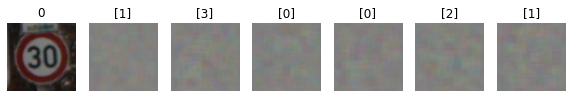

Epoch 10 g_loss= 0.9407983 d_loss= 0.66938436 real_acc= 0.02 fake_acc= 1.0
Epoch 20 g_loss= 0.80687517 d_loss= 0.6345941 real_acc= 0.68 fake_acc= 0.98
Epoch 30 g_loss= 0.92743134 d_loss= 0.6046152 real_acc= 0.58 fake_acc= 1.0
Epoch 40 g_loss= 0.9437292 d_loss= 0.58827066 real_acc= 0.58 fake_acc= 1.0
Epoch 50 g_loss= 0.8826161 d_loss= 0.58438504 real_acc= 0.74 fake_acc= 0.96
Epoch 60 g_loss= 0.8478942 d_loss= 0.5813863 real_acc= 0.74 fake_acc= 0.84
Epoch 70 g_loss= 0.79623413 d_loss= 0.60793626 real_acc= 0.78 fake_acc= 0.76
Epoch 80 g_loss= 0.9272551 d_loss= 0.6138629 real_acc= 0.76 fake_acc= 0.94
Epoch 90 g_loss= 1.2595862 d_loss= 0.5490404 real_acc= 0.66 fake_acc= 0.96
Epoch 100 g_loss= 1.6797885 d_loss= 0.5384528 real_acc= 0.52 fake_acc= 1.0


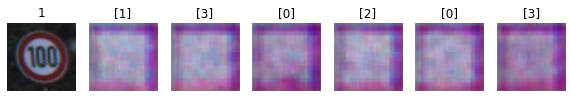

Epoch 110 g_loss= 1.4080356 d_loss= 0.5243004 real_acc= 0.62 fake_acc= 1.0
Epoch 120 g_loss= 1.8223109 d_loss= 0.42775288 real_acc= 0.7 fake_acc= 1.0
Epoch 130 g_loss= 1.8325741 d_loss= 0.35519972 real_acc= 0.78 fake_acc= 0.98
Epoch 140 g_loss= 1.3016444 d_loss= 0.47339582 real_acc= 0.68 fake_acc= 0.94
Epoch 150 g_loss= 1.3546747 d_loss= 0.4007759 real_acc= 0.86 fake_acc= 0.96
Epoch 160 g_loss= 2.6908605 d_loss= 0.2269404 real_acc= 0.9 fake_acc= 0.96
Epoch 170 g_loss= 2.2218745 d_loss= 0.3492385 real_acc= 0.88 fake_acc= 0.86
Epoch 180 g_loss= 2.188013 d_loss= 0.32197356 real_acc= 0.82 fake_acc= 0.94
Epoch 190 g_loss= 2.8992014 d_loss= 0.21145916 real_acc= 0.94 fake_acc= 0.96
Epoch 200 g_loss= 2.9160812 d_loss= 0.18552676 real_acc= 0.9 fake_acc= 0.96


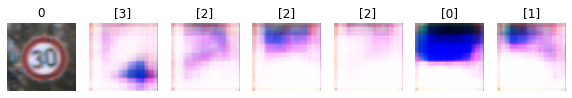

Epoch 210 g_loss= 3.4830859 d_loss= 0.1766593 real_acc= 0.84 fake_acc= 1.0
Epoch 220 g_loss= 3.8788605 d_loss= 0.27580398 real_acc= 0.76 fake_acc= 1.0
Epoch 230 g_loss= 3.4037004 d_loss= 0.32668695 real_acc= 0.74 fake_acc= 0.98
Epoch 240 g_loss= 2.101189 d_loss= 0.3516258 real_acc= 0.84 fake_acc= 0.88
Epoch 250 g_loss= 2.105079 d_loss= 0.3793709 real_acc= 0.76 fake_acc= 0.82
Epoch 260 g_loss= 2.0807743 d_loss= 0.32208303 real_acc= 0.92 fake_acc= 0.78
Epoch 270 g_loss= 1.8080914 d_loss= 0.3573329 real_acc= 0.94 fake_acc= 0.84
Epoch 280 g_loss= 1.3013781 d_loss= 0.44773442 real_acc= 0.9 fake_acc= 0.64
Epoch 290 g_loss= 1.6781255 d_loss= 0.6027113 real_acc= 0.72 fake_acc= 0.78
Epoch 300 g_loss= 0.97834015 d_loss= 0.5639936 real_acc= 0.84 fake_acc= 0.56


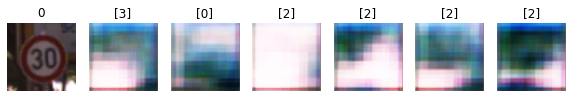

Epoch 310 g_loss= 1.3270739 d_loss= 0.3849214 real_acc= 0.86 fake_acc= 0.84
Epoch 320 g_loss= 1.7928941 d_loss= 0.39532202 real_acc= 0.86 fake_acc= 0.86
Epoch 330 g_loss= 1.6323805 d_loss= 0.39906955 real_acc= 0.86 fake_acc= 0.88
Epoch 340 g_loss= 1.2479898 d_loss= 0.464206 real_acc= 0.9 fake_acc= 0.72
Epoch 350 g_loss= 1.5749316 d_loss= 0.42821306 real_acc= 0.78 fake_acc= 0.88
Epoch 360 g_loss= 1.3939139 d_loss= 0.534962 real_acc= 0.78 fake_acc= 0.84
Epoch 370 g_loss= 1.7508187 d_loss= 0.40600058 real_acc= 0.76 fake_acc= 1.0
Epoch 380 g_loss= 1.6483545 d_loss= 0.4538201 real_acc= 0.72 fake_acc= 0.96
Epoch 390 g_loss= 1.1752117 d_loss= 0.4688826 real_acc= 0.82 fake_acc= 0.8
Epoch 400 g_loss= 1.3193636 d_loss= 0.680509 real_acc= 0.62 fake_acc= 0.88


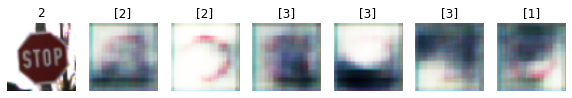

Epoch 410 g_loss= 0.80193496 d_loss= 0.5860762 real_acc= 0.84 fake_acc= 0.52
Epoch 420 g_loss= 1.4841646 d_loss= 0.49037397 real_acc= 0.68 fake_acc= 0.94
Epoch 430 g_loss= 1.7781502 d_loss= 0.4394238 real_acc= 0.7 fake_acc= 1.0
Epoch 440 g_loss= 1.6748883 d_loss= 0.47418565 real_acc= 0.76 fake_acc= 0.9
Epoch 450 g_loss= 0.6756723 d_loss= 0.682452 real_acc= 0.84 fake_acc= 0.38
Epoch 460 g_loss= 0.6584021 d_loss= 0.8698951 real_acc= 0.66 fake_acc= 0.34
Epoch 470 g_loss= 0.98628354 d_loss= 0.64911747 real_acc= 0.72 fake_acc= 0.68
Epoch 480 g_loss= 1.3972081 d_loss= 0.38365492 real_acc= 0.84 fake_acc= 0.9
Epoch 490 g_loss= 1.3340695 d_loss= 0.4170025 real_acc= 0.84 fake_acc= 0.84
Epoch 500 g_loss= 1.5037652 d_loss= 0.4190604 real_acc= 0.78 fake_acc= 0.94


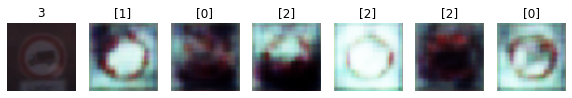

Epoch 510 g_loss= 1.0692569 d_loss= 0.3526184 real_acc= 0.96 fake_acc= 0.76
Epoch 520 g_loss= 1.3612546 d_loss= 0.59499866 real_acc= 0.52 fake_acc= 0.88
Epoch 530 g_loss= 0.92489564 d_loss= 0.6731192 real_acc= 0.66 fake_acc= 0.64
Epoch 540 g_loss= 0.9867319 d_loss= 0.6434765 real_acc= 0.64 fake_acc= 0.64
Epoch 550 g_loss= 1.3638489 d_loss= 0.4106659 real_acc= 0.9 fake_acc= 0.76
Epoch 560 g_loss= 1.6070682 d_loss= 0.31336027 real_acc= 0.88 fake_acc= 0.92
Epoch 570 g_loss= 1.3749385 d_loss= 0.39208877 real_acc= 0.9 fake_acc= 0.86
Epoch 580 g_loss= 1.0925403 d_loss= 0.61767685 real_acc= 0.64 fake_acc= 0.78
Epoch 590 g_loss= 1.2224892 d_loss= 0.50836647 real_acc= 0.68 fake_acc= 0.74
Epoch 600 g_loss= 0.9743854 d_loss= 0.57744735 real_acc= 0.68 fake_acc= 0.74


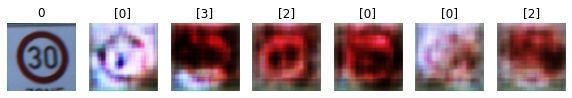

Epoch 610 g_loss= 0.8030133 d_loss= 0.6794057 real_acc= 0.62 fake_acc= 0.5
Epoch 620 g_loss= 0.8078754 d_loss= 0.5899967 real_acc= 0.78 fake_acc= 0.58
Epoch 630 g_loss= 1.1780003 d_loss= 0.4147821 real_acc= 0.88 fake_acc= 0.78
Epoch 640 g_loss= 1.2532166 d_loss= 0.37717223 real_acc= 0.82 fake_acc= 0.94
Epoch 650 g_loss= 1.3315861 d_loss= 0.5086036 real_acc= 0.56 fake_acc= 0.92
Epoch 660 g_loss= 1.0470964 d_loss= 0.58843553 real_acc= 0.68 fake_acc= 0.84
Epoch 670 g_loss= 1.1446911 d_loss= 0.5601193 real_acc= 0.64 fake_acc= 0.76
Epoch 680 g_loss= 1.1989746 d_loss= 0.5363323 real_acc= 0.58 fake_acc= 0.94
Epoch 690 g_loss= 1.4132248 d_loss= 0.38078004 real_acc= 0.88 fake_acc= 0.92
Epoch 700 g_loss= 1.0981244 d_loss= 0.4170307 real_acc= 0.86 fake_acc= 0.86


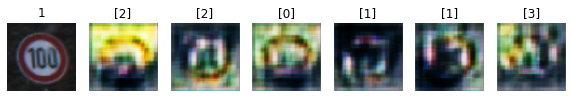

Epoch 710 g_loss= 1.0446397 d_loss= 0.45101374 real_acc= 0.86 fake_acc= 0.9
Epoch 720 g_loss= 1.1310592 d_loss= 0.51722074 real_acc= 0.68 fake_acc= 0.78
Epoch 730 g_loss= 0.83476794 d_loss= 0.63264656 real_acc= 0.66 fake_acc= 0.56
Epoch 740 g_loss= 0.7285151 d_loss= 0.8241379 real_acc= 0.6 fake_acc= 0.46
Epoch 750 g_loss= 1.2301736 d_loss= 0.5560165 real_acc= 0.62 fake_acc= 0.9
Epoch 760 g_loss= 1.2986253 d_loss= 0.38877812 real_acc= 0.9 fake_acc= 0.92
Epoch 770 g_loss= 1.1541896 d_loss= 0.5085272 real_acc= 0.8 fake_acc= 0.68
Epoch 780 g_loss= 1.4181503 d_loss= 0.44165558 real_acc= 0.82 fake_acc= 0.96
Epoch 790 g_loss= 1.1672282 d_loss= 0.58049643 real_acc= 0.68 fake_acc= 0.76
Epoch 800 g_loss= 1.3223176 d_loss= 0.58558166 real_acc= 0.68 fake_acc= 0.88


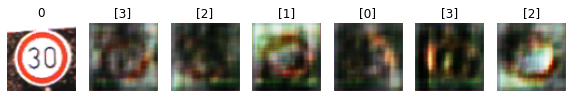

Epoch 810 g_loss= 1.3587909 d_loss= 0.48793393 real_acc= 0.68 fake_acc= 0.94
Epoch 820 g_loss= 0.919642 d_loss= 0.51078534 real_acc= 0.86 fake_acc= 0.7
Epoch 830 g_loss= 1.3128734 d_loss= 0.48225063 real_acc= 0.72 fake_acc= 0.9
Epoch 840 g_loss= 1.5684149 d_loss= 0.3106047 real_acc= 0.92 fake_acc= 0.92
Epoch 850 g_loss= 1.0806794 d_loss= 0.63170475 real_acc= 0.66 fake_acc= 0.68
Epoch 860 g_loss= 0.5704324 d_loss= 1.003018 real_acc= 0.52 fake_acc= 0.34
Epoch 870 g_loss= 0.94972396 d_loss= 0.5691312 real_acc= 0.62 fake_acc= 0.74
Epoch 880 g_loss= 1.2224817 d_loss= 0.34621847 real_acc= 0.94 fake_acc= 0.9
Epoch 890 g_loss= 1.8113157 d_loss= 0.3176682 real_acc= 0.88 fake_acc= 0.92
Epoch 900 g_loss= 1.8007975 d_loss= 0.22237566 real_acc= 0.94 fake_acc= 0.96


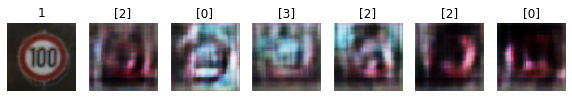

Epoch 910 g_loss= 1.4177575 d_loss= 0.4397909 real_acc= 0.8 fake_acc= 0.88
Epoch 920 g_loss= 1.0264045 d_loss= 0.74840856 real_acc= 0.62 fake_acc= 0.7
Epoch 930 g_loss= 1.1165538 d_loss= 0.7263936 real_acc= 0.56 fake_acc= 0.76
Epoch 940 g_loss= 1.6686888 d_loss= 0.40660262 real_acc= 0.74 fake_acc= 1.0
Epoch 950 g_loss= 1.8354036 d_loss= 0.24345112 real_acc= 0.96 fake_acc= 0.96
Epoch 960 g_loss= 1.532222 d_loss= 0.3372784 real_acc= 0.84 fake_acc= 0.94
Epoch 970 g_loss= 1.1410325 d_loss= 0.5536926 real_acc= 0.78 fake_acc= 0.66
Epoch 980 g_loss= 0.9349464 d_loss= 0.70479965 real_acc= 0.62 fake_acc= 0.56
Epoch 990 g_loss= 1.0237906 d_loss= 0.476171 real_acc= 0.92 fake_acc= 0.64
Epoch 1000 g_loss= 1.3795295 d_loss= 0.4593432 real_acc= 0.78 fake_acc= 0.9


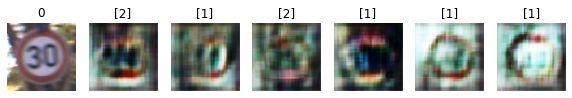

Epoch 1010 g_loss= 1.501558 d_loss= 0.61573046 real_acc= 0.62 fake_acc= 0.82
Epoch 1020 g_loss= 1.4055383 d_loss= 0.38009915 real_acc= 0.82 fake_acc= 0.88
Epoch 1030 g_loss= 1.9895494 d_loss= 0.26640725 real_acc= 0.9 fake_acc= 0.92
Epoch 1040 g_loss= 1.674784 d_loss= 0.33914602 real_acc= 0.82 fake_acc= 0.94
Epoch 1050 g_loss= 1.2054162 d_loss= 0.39489278 real_acc= 0.9 fake_acc= 0.8
Epoch 1060 g_loss= 0.63228464 d_loss= 0.8285879 real_acc= 0.6 fake_acc= 0.32
Epoch 1070 g_loss= 0.98462415 d_loss= 0.5605941 real_acc= 0.78 fake_acc= 0.76
Epoch 1080 g_loss= 1.6298774 d_loss= 0.2956283 real_acc= 0.92 fake_acc= 1.0
Epoch 1090 g_loss= 1.964732 d_loss= 0.21707067 real_acc= 0.94 fake_acc= 1.0
Epoch 1100 g_loss= 1.6827849 d_loss= 0.45982286 real_acc= 0.66 fake_acc= 0.98


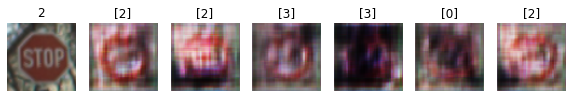

Epoch 1110 g_loss= 1.0874141 d_loss= 0.593474 real_acc= 0.6 fake_acc= 0.86
Epoch 1120 g_loss= 1.3284967 d_loss= 0.41341156 real_acc= 0.7 fake_acc= 1.0
Epoch 1130 g_loss= 1.8422055 d_loss= 0.34757942 real_acc= 0.72 fake_acc= 0.98
Epoch 1140 g_loss= 1.4022686 d_loss= 0.43991178 real_acc= 0.7 fake_acc= 0.98
Epoch 1150 g_loss= 1.2419819 d_loss= 0.3853603 real_acc= 0.82 fake_acc= 0.94
Epoch 1160 g_loss= 1.5577258 d_loss= 0.3280307 real_acc= 0.84 fake_acc= 0.98
Epoch 1170 g_loss= 1.4082358 d_loss= 0.3507498 real_acc= 0.82 fake_acc= 0.94
Epoch 1180 g_loss= 1.014043 d_loss= 0.5098413 real_acc= 0.82 fake_acc= 0.72
Epoch 1190 g_loss= 0.8924911 d_loss= 0.8082007 real_acc= 0.72 fake_acc= 0.62
Epoch 1200 g_loss= 1.523134 d_loss= 0.36522835 real_acc= 0.84 fake_acc= 0.82


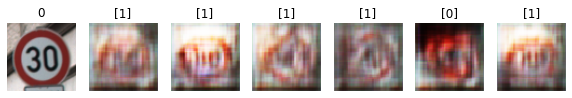

Epoch 1210 g_loss= 1.9099256 d_loss= 0.27550074 real_acc= 0.86 fake_acc= 0.94
Epoch 1220 g_loss= 1.5215693 d_loss= 0.34873903 real_acc= 0.84 fake_acc= 0.92
Epoch 1230 g_loss= 1.0180256 d_loss= 0.45792967 real_acc= 0.88 fake_acc= 0.68
Epoch 1240 g_loss= 1.0969445 d_loss= 0.4468718 real_acc= 0.88 fake_acc= 0.68
Epoch 1250 g_loss= 1.7263815 d_loss= 0.298958 real_acc= 0.88 fake_acc= 0.92
Epoch 1260 g_loss= 2.1215332 d_loss= 0.2912819 real_acc= 0.8 fake_acc= 0.98
Epoch 1270 g_loss= 1.5424771 d_loss= 0.3038379 real_acc= 0.84 fake_acc= 0.94
Epoch 1280 g_loss= 1.1872241 d_loss= 0.6531305 real_acc= 0.68 fake_acc= 0.74
Epoch 1290 g_loss= 1.2476537 d_loss= 0.514112 real_acc= 0.72 fake_acc= 0.74
Epoch 1300 g_loss= 1.2941815 d_loss= 0.582318 real_acc= 0.62 fake_acc= 0.88


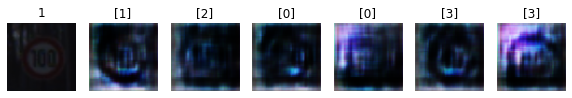

Epoch 1310 g_loss= 1.6070857 d_loss= 0.36071867 real_acc= 0.86 fake_acc= 0.96
Epoch 1320 g_loss= 1.7255788 d_loss= 0.33136922 real_acc= 0.78 fake_acc= 1.0
Epoch 1330 g_loss= 1.6342969 d_loss= 0.35414565 real_acc= 0.84 fake_acc= 0.88
Epoch 1340 g_loss= 1.6878492 d_loss= 0.2624734 real_acc= 0.94 fake_acc= 0.94
Epoch 1350 g_loss= 1.7489682 d_loss= 0.23107316 real_acc= 0.98 fake_acc= 0.94
Epoch 1360 g_loss= 1.6856304 d_loss= 0.33946177 real_acc= 0.84 fake_acc= 0.96
Epoch 1370 g_loss= 1.3324554 d_loss= 0.4640817 real_acc= 0.74 fake_acc= 0.8
Epoch 1380 g_loss= 1.5662618 d_loss= 0.40972632 real_acc= 0.78 fake_acc= 0.9
Epoch 1390 g_loss= 1.8403429 d_loss= 0.2672903 real_acc= 0.92 fake_acc= 0.9
Epoch 1400 g_loss= 1.7620293 d_loss= 0.3473599 real_acc= 0.8 fake_acc= 0.96


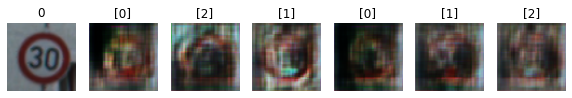

Epoch 1410 g_loss= 1.1018767 d_loss= 0.41946644 real_acc= 0.88 fake_acc= 0.76
Epoch 1420 g_loss= 1.0112503 d_loss= 0.47052717 real_acc= 0.88 fake_acc= 0.62
Epoch 1430 g_loss= 1.8016918 d_loss= 0.4204649 real_acc= 0.74 fake_acc= 0.92
Epoch 1440 g_loss= 2.9387436 d_loss= 0.2552009 real_acc= 0.78 fake_acc= 1.0
Epoch 1450 g_loss= 2.6475244 d_loss= 0.2232846 real_acc= 0.84 fake_acc= 0.98
Epoch 1460 g_loss= 1.296099 d_loss= 0.582045 real_acc= 0.72 fake_acc= 0.72
Epoch 1470 g_loss= 0.7426771 d_loss= 0.57791007 real_acc= 0.82 fake_acc= 0.48
Epoch 1480 g_loss= 1.2898787 d_loss= 0.33123246 real_acc= 0.92 fake_acc= 0.9
Epoch 1490 g_loss= 2.6650321 d_loss= 0.14225298 real_acc= 0.92 fake_acc= 1.0
Epoch 1500 g_loss= 1.908202 d_loss= 0.19154957 real_acc= 0.96 fake_acc= 0.98


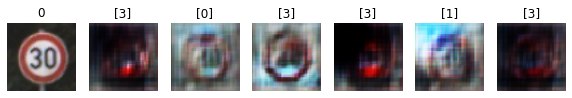

Epoch 1510 g_loss= 1.8838254 d_loss= 0.324865 real_acc= 0.82 fake_acc= 0.98
Epoch 1520 g_loss= 1.5664847 d_loss= 0.39353392 real_acc= 0.8 fake_acc= 0.96
Epoch 1530 g_loss= 1.5945429 d_loss= 0.41100958 real_acc= 0.74 fake_acc= 0.88
Epoch 1540 g_loss= 1.3306706 d_loss= 0.41216964 real_acc= 0.8 fake_acc= 0.78
Epoch 1550 g_loss= 1.3247341 d_loss= 0.3890515 real_acc= 0.82 fake_acc= 0.94
Epoch 1560 g_loss= 2.0622747 d_loss= 0.2052629 real_acc= 0.86 fake_acc= 1.0
Epoch 1570 g_loss= 2.1765008 d_loss= 0.15871762 real_acc= 0.98 fake_acc= 1.0
Epoch 1580 g_loss= 1.9421769 d_loss= 0.26798216 real_acc= 0.88 fake_acc= 0.9
Epoch 1590 g_loss= 1.1943859 d_loss= 0.54294896 real_acc= 0.7 fake_acc= 0.84
Epoch 1600 g_loss= 1.5182539 d_loss= 0.40430772 real_acc= 0.78 fake_acc= 0.94


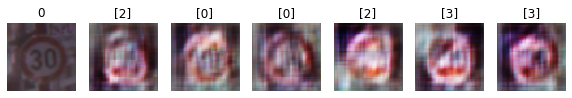

Epoch 1610 g_loss= 1.7063278 d_loss= 0.23785609 real_acc= 0.94 fake_acc= 0.9
Epoch 1620 g_loss= 1.8084388 d_loss= 0.25490624 real_acc= 0.86 fake_acc= 0.98
Epoch 1630 g_loss= 1.5301403 d_loss= 0.33662623 real_acc= 0.86 fake_acc= 0.86
Epoch 1640 g_loss= 1.3472868 d_loss= 0.32016313 real_acc= 0.92 fake_acc= 0.88
Epoch 1650 g_loss= 1.7416576 d_loss= 0.3420719 real_acc= 0.88 fake_acc= 0.8
Epoch 1660 g_loss= 1.31237 d_loss= 0.4149657 real_acc= 0.9 fake_acc= 0.64
Epoch 1670 g_loss= 1.8572131 d_loss= 0.3324952 real_acc= 0.9 fake_acc= 0.8
Epoch 1680 g_loss= 1.6358539 d_loss= 0.31368244 real_acc= 0.86 fake_acc= 0.88
Epoch 1690 g_loss= 1.7242877 d_loss= 0.3486243 real_acc= 0.88 fake_acc= 0.9
Epoch 1700 g_loss= 1.7343972 d_loss= 0.30759156 real_acc= 0.92 fake_acc= 0.96


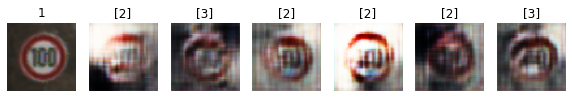

Epoch 1710 g_loss= 1.4102674 d_loss= 0.30250436 real_acc= 0.88 fake_acc= 0.92
Epoch 1720 g_loss= 1.8209769 d_loss= 0.21702689 real_acc= 0.96 fake_acc= 0.94
Epoch 1730 g_loss= 1.8541336 d_loss= 0.24121016 real_acc= 0.9 fake_acc= 0.96
Epoch 1740 g_loss= 1.7990154 d_loss= 0.2444543 real_acc= 0.92 fake_acc= 0.92
Epoch 1750 g_loss= 1.7163092 d_loss= 0.2538439 real_acc= 0.88 fake_acc= 0.88
Epoch 1760 g_loss= 1.7286686 d_loss= 0.32066655 real_acc= 0.86 fake_acc= 0.9
Epoch 1770 g_loss= 1.562518 d_loss= 0.33623385 real_acc= 0.9 fake_acc= 0.9
Epoch 1780 g_loss= 1.331485 d_loss= 0.30999976 real_acc= 0.96 fake_acc= 0.8
Epoch 1790 g_loss= 1.3193952 d_loss= 0.30338374 real_acc= 0.96 fake_acc= 0.86
Epoch 1800 g_loss= 1.5500184 d_loss= 0.35371634 real_acc= 0.88 fake_acc= 0.76


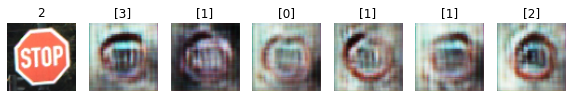

Epoch 1810 g_loss= 1.7595336 d_loss= 0.42617112 real_acc= 0.74 fake_acc= 0.88
Epoch 1820 g_loss= 2.0003085 d_loss= 0.2499262 real_acc= 0.92 fake_acc= 0.9
Epoch 1830 g_loss= 2.1179068 d_loss= 0.20600608 real_acc= 0.96 fake_acc= 0.86
Epoch 1840 g_loss= 1.7366595 d_loss= 0.30504972 real_acc= 0.94 fake_acc= 0.9
Epoch 1850 g_loss= 1.4820893 d_loss= 0.3366493 real_acc= 0.9 fake_acc= 0.88
Epoch 1860 g_loss= 1.6839072 d_loss= 0.45263314 real_acc= 0.66 fake_acc= 0.96
Epoch 1870 g_loss= 1.7717223 d_loss= 0.390944 real_acc= 0.88 fake_acc= 0.86
Epoch 1880 g_loss= 1.0753813 d_loss= 0.51307 real_acc= 0.84 fake_acc= 0.68
Epoch 1890 g_loss= 1.7933731 d_loss= 0.43198708 real_acc= 0.7 fake_acc= 0.88
Epoch 1900 g_loss= 1.7960647 d_loss= 0.30437234 real_acc= 0.86 fake_acc= 0.96


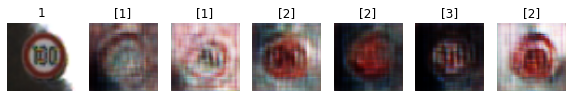

Epoch 1910 g_loss= 1.2019238 d_loss= 0.41956034 real_acc= 0.84 fake_acc= 0.86
Epoch 1920 g_loss= 1.4129803 d_loss= 0.3136325 real_acc= 0.92 fake_acc= 0.88
Epoch 1930 g_loss= 2.119093 d_loss= 0.20374459 real_acc= 0.98 fake_acc= 0.98
Epoch 1940 g_loss= 1.8618649 d_loss= 0.29614198 real_acc= 0.88 fake_acc= 0.94
Epoch 1950 g_loss= 1.4021205 d_loss= 0.41773424 real_acc= 0.84 fake_acc= 0.78
Epoch 1960 g_loss= 1.6196737 d_loss= 0.32301074 real_acc= 0.88 fake_acc= 0.82
Epoch 1970 g_loss= 1.6998756 d_loss= 0.27793524 real_acc= 0.96 fake_acc= 0.9
Epoch 1980 g_loss= 1.4477369 d_loss= 0.36779523 real_acc= 0.76 fake_acc= 0.94
Epoch 1990 g_loss= 1.3591357 d_loss= 0.38853306 real_acc= 0.8 fake_acc= 0.88
Epoch 2000 g_loss= 1.4572728 d_loss= 0.30971837 real_acc= 0.9 fake_acc= 0.86


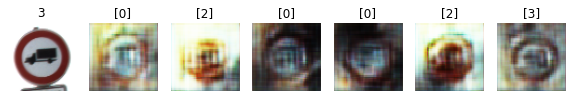

Epoch 2010 g_loss= 1.4286636 d_loss= 0.29225168 real_acc= 0.9 fake_acc= 0.86
Epoch 2020 g_loss= 1.4016647 d_loss= 0.2797397 real_acc= 0.96 fake_acc= 0.92
Epoch 2030 g_loss= 1.8043246 d_loss= 0.38676178 real_acc= 0.78 fake_acc= 0.9
Epoch 2040 g_loss= 2.0434072 d_loss= 0.22227286 real_acc= 0.92 fake_acc= 0.94
Epoch 2050 g_loss= 2.1689196 d_loss= 0.21287963 real_acc= 0.94 fake_acc= 1.0
Epoch 2060 g_loss= 1.8787177 d_loss= 0.20834354 real_acc= 0.94 fake_acc= 0.98
Epoch 2070 g_loss= 1.6575218 d_loss= 0.3633891 real_acc= 0.8 fake_acc= 0.96
Epoch 2080 g_loss= 1.9832288 d_loss= 0.29599112 real_acc= 0.8 fake_acc= 1.0
Epoch 2090 g_loss= 3.066693 d_loss= 0.2250188 real_acc= 0.92 fake_acc= 1.0
Epoch 2100 g_loss= 1.9176586 d_loss= 0.2542202 real_acc= 0.86 fake_acc= 0.94


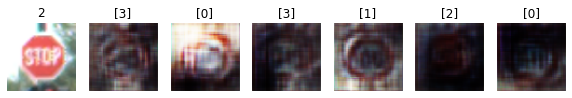

Epoch 2110 g_loss= 1.3228602 d_loss= 0.43264005 real_acc= 0.74 fake_acc= 0.8
Epoch 2120 g_loss= 2.3049772 d_loss= 0.33038867 real_acc= 0.82 fake_acc= 1.0
Epoch 2130 g_loss= 1.5909781 d_loss= 0.35209367 real_acc= 0.86 fake_acc= 0.84
Epoch 2140 g_loss= 1.3640583 d_loss= 0.4321893 real_acc= 0.76 fake_acc= 0.84
Epoch 2150 g_loss= 2.2140257 d_loss= 0.23253477 real_acc= 0.88 fake_acc= 0.98
Epoch 2160 g_loss= 2.2806537 d_loss= 0.24740373 real_acc= 0.88 fake_acc= 0.96
Epoch 2170 g_loss= 1.3619522 d_loss= 0.31362525 real_acc= 0.94 fake_acc= 0.86
Epoch 2180 g_loss= 1.8685437 d_loss= 0.36820495 real_acc= 0.82 fake_acc= 0.98
Epoch 2190 g_loss= 2.9866605 d_loss= 0.27634028 real_acc= 0.84 fake_acc= 0.98
Epoch 2200 g_loss= 1.7927542 d_loss= 0.30791652 real_acc= 0.8 fake_acc= 0.96


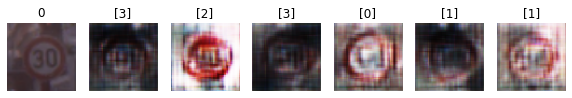

Epoch 2210 g_loss= 1.5869576 d_loss= 0.32994837 real_acc= 0.92 fake_acc= 0.9
Epoch 2220 g_loss= 1.631639 d_loss= 0.26232493 real_acc= 0.94 fake_acc= 0.92
Epoch 2230 g_loss= 1.5184991 d_loss= 0.31377646 real_acc= 0.92 fake_acc= 0.82
Epoch 2240 g_loss= 1.6823571 d_loss= 0.2821042 real_acc= 0.92 fake_acc= 0.92
Epoch 2250 g_loss= 2.5605328 d_loss= 0.29277426 real_acc= 0.76 fake_acc= 1.0
Epoch 2260 g_loss= 2.077028 d_loss= 0.26612097 real_acc= 0.9 fake_acc= 0.96
Epoch 2270 g_loss= 1.8780774 d_loss= 0.16888344 real_acc= 0.98 fake_acc= 0.96
Epoch 2280 g_loss= 2.6076264 d_loss= 0.22768702 real_acc= 0.86 fake_acc= 1.0
Epoch 2290 g_loss= 2.042237 d_loss= 0.25578797 real_acc= 0.84 fake_acc= 0.96
Epoch 2300 g_loss= 2.188476 d_loss= 0.2287044 real_acc= 0.92 fake_acc= 0.88


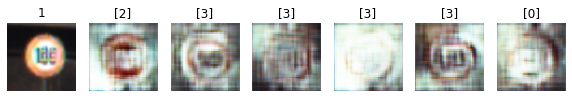

Epoch 2310 g_loss= 2.1550112 d_loss= 0.18130462 real_acc= 0.96 fake_acc= 0.94
Epoch 2320 g_loss= 1.9711987 d_loss= 0.21163955 real_acc= 0.94 fake_acc= 0.94
Epoch 2330 g_loss= 1.7158976 d_loss= 0.30853474 real_acc= 0.86 fake_acc= 0.9
Epoch 2340 g_loss= 1.8281817 d_loss= 0.19752514 real_acc= 0.96 fake_acc= 0.98
Epoch 2350 g_loss= 2.5414894 d_loss= 0.22715566 real_acc= 0.92 fake_acc= 1.0
Epoch 2360 g_loss= 1.643836 d_loss= 0.24887165 real_acc= 0.9 fake_acc= 0.98
Epoch 2370 g_loss= 2.0568244 d_loss= 0.25437278 real_acc= 0.9 fake_acc= 1.0
Epoch 2380 g_loss= 1.8251262 d_loss= 0.23145258 real_acc= 0.92 fake_acc= 0.94
Epoch 2390 g_loss= 2.2744176 d_loss= 0.23062184 real_acc= 0.86 fake_acc= 1.0
Epoch 2400 g_loss= 1.9118978 d_loss= 0.27038053 real_acc= 0.9 fake_acc= 0.98


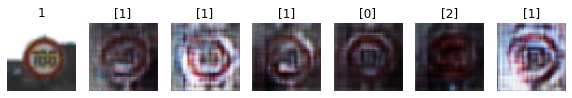

Epoch 2410 g_loss= 2.3045588 d_loss= 0.2212072 real_acc= 0.9 fake_acc= 1.0
Epoch 2420 g_loss= 1.8133099 d_loss= 0.20001695 real_acc= 0.9 fake_acc= 0.98
Epoch 2430 g_loss= 2.1426618 d_loss= 0.28667238 real_acc= 0.8 fake_acc= 1.0
Epoch 2440 g_loss= 1.8761611 d_loss= 0.22697948 real_acc= 0.94 fake_acc= 0.92
Epoch 2450 g_loss= 2.056972 d_loss= 0.1804575 real_acc= 0.94 fake_acc= 0.96
Epoch 2460 g_loss= 1.837497 d_loss= 0.17962565 real_acc= 0.94 fake_acc= 1.0
Epoch 2470 g_loss= 2.3040655 d_loss= 0.26519263 real_acc= 0.84 fake_acc= 1.0
Epoch 2480 g_loss= 2.0070322 d_loss= 0.21924484 real_acc= 0.94 fake_acc= 0.96
Epoch 2490 g_loss= 2.041145 d_loss= 0.15833163 real_acc= 0.94 fake_acc= 0.98
Epoch 2500 g_loss= 1.9015518 d_loss= 0.1990841 real_acc= 0.94 fake_acc= 1.0


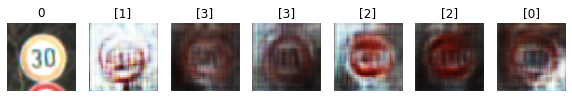

Epoch 2510 g_loss= 2.402034 d_loss= 0.19217929 real_acc= 0.9 fake_acc= 1.0
Epoch 2520 g_loss= 2.3948748 d_loss= 0.16770925 real_acc= 0.96 fake_acc= 1.0
Epoch 2530 g_loss= 2.3422003 d_loss= 0.22622809 real_acc= 0.88 fake_acc= 1.0
Epoch 2540 g_loss= 2.3306284 d_loss= 0.20365894 real_acc= 0.92 fake_acc= 1.0
Epoch 2550 g_loss= 2.5294068 d_loss= 0.16482495 real_acc= 0.88 fake_acc= 0.98
Epoch 2560 g_loss= 1.9401267 d_loss= 0.21597648 real_acc= 0.9 fake_acc= 1.0
Epoch 2570 g_loss= 2.2755804 d_loss= 0.19938606 real_acc= 0.94 fake_acc= 1.0
Epoch 2580 g_loss= 2.4429517 d_loss= 0.19960254 real_acc= 0.9 fake_acc= 1.0
Epoch 2590 g_loss= 2.8635643 d_loss= 0.23779508 real_acc= 0.84 fake_acc= 1.0
Epoch 2600 g_loss= 2.0160942 d_loss= 0.15630354 real_acc= 0.96 fake_acc= 1.0


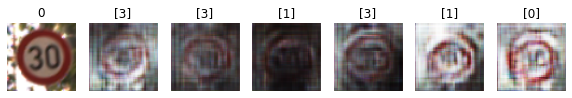

Epoch 2610 g_loss= 3.0946913 d_loss= 0.17662898 real_acc= 0.88 fake_acc= 1.0
Epoch 2620 g_loss= 2.679436 d_loss= 0.13783664 real_acc= 0.96 fake_acc= 1.0
Epoch 2630 g_loss= 2.226824 d_loss= 0.16107993 real_acc= 0.94 fake_acc= 1.0
Epoch 2640 g_loss= 2.202522 d_loss= 0.15437089 real_acc= 0.98 fake_acc= 0.96
Epoch 2650 g_loss= 2.4608278 d_loss= 0.20268582 real_acc= 0.86 fake_acc= 1.0
Epoch 2660 g_loss= 2.658417 d_loss= 0.13194363 real_acc= 0.94 fake_acc= 0.98
Epoch 2670 g_loss= 2.6354272 d_loss= 0.21682812 real_acc= 0.84 fake_acc= 1.0
Epoch 2680 g_loss= 2.5942426 d_loss= 0.22919777 real_acc= 0.88 fake_acc= 1.0
Epoch 2690 g_loss= 2.130542 d_loss= 0.15433311 real_acc= 0.98 fake_acc= 0.96
Epoch 2700 g_loss= 2.1164005 d_loss= 0.17859313 real_acc= 0.92 fake_acc= 1.0


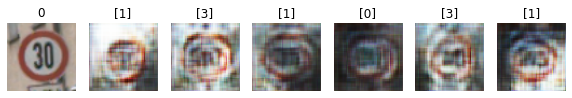

Epoch 2710 g_loss= 2.3991342 d_loss= 0.17675701 real_acc= 0.86 fake_acc= 1.0
Epoch 2720 g_loss= 2.2893248 d_loss= 0.15582938 real_acc= 0.92 fake_acc= 1.0
Epoch 2730 g_loss= 2.5560164 d_loss= 0.13310711 real_acc= 0.94 fake_acc= 1.0
Epoch 2740 g_loss= 2.3204029 d_loss= 0.16552949 real_acc= 0.92 fake_acc= 0.98
Epoch 2750 g_loss= 2.2445116 d_loss= 0.13880536 real_acc= 0.96 fake_acc= 0.98
Epoch 2760 g_loss= 2.7264621 d_loss= 0.17893788 real_acc= 0.88 fake_acc= 1.0
Epoch 2770 g_loss= 2.3854406 d_loss= 0.16387367 real_acc= 0.96 fake_acc= 0.98
Epoch 2780 g_loss= 2.7055938 d_loss= 0.1607624 real_acc= 0.9 fake_acc= 0.98
Epoch 2790 g_loss= 2.1678312 d_loss= 0.15353683 real_acc= 0.92 fake_acc= 1.0
Epoch 2800 g_loss= 1.8824911 d_loss= 0.1731359 real_acc= 0.98 fake_acc= 0.94


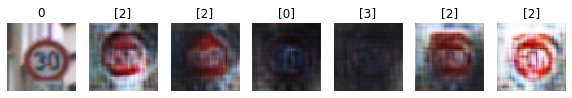

Epoch 2810 g_loss= 2.6083639 d_loss= 0.20566356 real_acc= 0.86 fake_acc= 1.0
Epoch 2820 g_loss= 2.8626494 d_loss= 0.17307074 real_acc= 0.9 fake_acc= 1.0
Epoch 2830 g_loss= 2.370762 d_loss= 0.12198146 real_acc= 0.94 fake_acc= 1.0
Epoch 2840 g_loss= 2.8687835 d_loss= 0.18450728 real_acc= 0.92 fake_acc= 1.0
Epoch 2850 g_loss= 2.1521003 d_loss= 0.16406533 real_acc= 0.96 fake_acc= 0.98
Epoch 2860 g_loss= 3.2034867 d_loss= 0.21766353 real_acc= 0.8 fake_acc= 1.0
Epoch 2870 g_loss= 1.7196927 d_loss= 0.19525784 real_acc= 1.0 fake_acc= 0.88
Epoch 2880 g_loss= 3.084497 d_loss= 0.1552164 real_acc= 0.9 fake_acc= 1.0
Epoch 2890 g_loss= 2.8357077 d_loss= 0.1279685 real_acc= 0.94 fake_acc= 1.0
Epoch 2900 g_loss= 2.4899466 d_loss= 0.14532855 real_acc= 0.92 fake_acc= 1.0


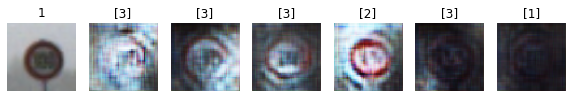

Epoch 2910 g_loss= 3.031418 d_loss= 0.10340689 real_acc= 0.98 fake_acc= 1.0
Epoch 2920 g_loss= 2.7177517 d_loss= 0.14832327 real_acc= 0.92 fake_acc= 1.0
Epoch 2930 g_loss= 2.7584217 d_loss= 0.16963664 real_acc= 0.84 fake_acc= 1.0
Epoch 2940 g_loss= 2.7080958 d_loss= 0.1383526 real_acc= 0.94 fake_acc= 0.98
Epoch 2950 g_loss= 2.861856 d_loss= 0.10464792 real_acc= 0.94 fake_acc= 1.0
Epoch 2960 g_loss= 2.3439512 d_loss= 0.10996799 real_acc= 0.98 fake_acc= 1.0
Epoch 2970 g_loss= 2.6809628 d_loss= 0.12916298 real_acc= 0.94 fake_acc= 1.0
Epoch 2980 g_loss= 3.0142322 d_loss= 0.16529979 real_acc= 0.92 fake_acc= 1.0
Epoch 2990 g_loss= 2.619615 d_loss= 0.10633892 real_acc= 0.98 fake_acc= 1.0
Epoch 3000 g_loss= 3.0437708 d_loss= 0.16002575 real_acc= 0.88 fake_acc= 1.0


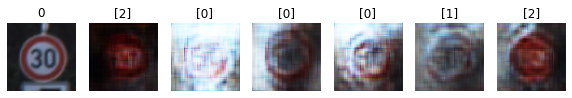

Epoch 3010 g_loss= 2.354031 d_loss= 0.17279431 real_acc= 0.92 fake_acc= 0.98
Epoch 3020 g_loss= 3.6526632 d_loss= 0.14666502 real_acc= 0.96 fake_acc= 1.0
Epoch 3030 g_loss= 2.3111649 d_loss= 0.122600034 real_acc= 1.0 fake_acc= 0.98
Epoch 3040 g_loss= 3.2873228 d_loss= 0.087344624 real_acc= 0.98 fake_acc= 1.0
Epoch 3050 g_loss= 2.712775 d_loss= 0.17574218 real_acc= 0.94 fake_acc= 1.0
Epoch 3060 g_loss= 2.658054 d_loss= 0.12273921 real_acc= 0.94 fake_acc= 1.0
Epoch 3070 g_loss= 3.0443494 d_loss= 0.107335545 real_acc= 0.96 fake_acc= 1.0
Epoch 3080 g_loss= 3.0761151 d_loss= 0.11241586 real_acc= 0.96 fake_acc= 1.0
Epoch 3090 g_loss= 2.9340277 d_loss= 0.11716837 real_acc= 0.96 fake_acc= 1.0
Epoch 3100 g_loss= 3.4399045 d_loss= 0.09502976 real_acc= 0.98 fake_acc= 1.0


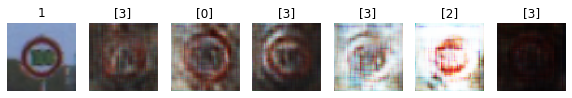

Epoch 3110 g_loss= 2.4386213 d_loss= 0.10446624 real_acc= 1.0 fake_acc= 1.0
Epoch 3120 g_loss= 2.6404743 d_loss= 0.10609466 real_acc= 1.0 fake_acc= 1.0
Epoch 3130 g_loss= 3.3140674 d_loss= 0.12842596 real_acc= 0.92 fake_acc= 1.0
Epoch 3140 g_loss= 2.1831858 d_loss= 0.11463612 real_acc= 0.98 fake_acc= 1.0
Epoch 3150 g_loss= 3.1355176 d_loss= 0.08860992 real_acc= 0.96 fake_acc= 1.0
Epoch 3160 g_loss= 3.9831727 d_loss= 0.085298434 real_acc= 0.98 fake_acc= 1.0
Epoch 3170 g_loss= 3.0581803 d_loss= 0.10150584 real_acc= 0.98 fake_acc= 1.0
Epoch 3180 g_loss= 2.7133257 d_loss= 0.12936696 real_acc= 0.92 fake_acc= 1.0
Epoch 3190 g_loss= 2.509612 d_loss= 0.10503781 real_acc= 1.0 fake_acc= 1.0
Epoch 3200 g_loss= 3.412731 d_loss= 0.08895464 real_acc= 0.96 fake_acc= 1.0


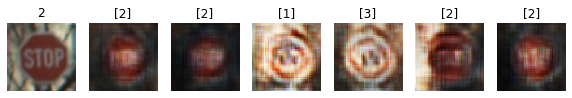

Epoch 3210 g_loss= 3.1100311 d_loss= 0.082460076 real_acc= 0.98 fake_acc= 1.0
Epoch 3220 g_loss= 3.26211 d_loss= 0.12863414 real_acc= 0.92 fake_acc= 1.0
Epoch 3230 g_loss= 2.9987566 d_loss= 0.08733566 real_acc= 0.98 fake_acc= 1.0
Epoch 3240 g_loss= 2.0306563 d_loss= 0.11501898 real_acc= 1.0 fake_acc= 1.0
Epoch 3250 g_loss= 3.234477 d_loss= 0.069750324 real_acc= 1.0 fake_acc= 1.0
Epoch 3260 g_loss= 3.6756916 d_loss= 0.11230844 real_acc= 0.92 fake_acc= 1.0
Epoch 3270 g_loss= 2.2278337 d_loss= 0.15362014 real_acc= 0.96 fake_acc= 0.96
Epoch 3280 g_loss= 3.5312688 d_loss= 0.08246768 real_acc= 0.96 fake_acc= 1.0
Epoch 3290 g_loss= 3.743004 d_loss= 0.11486704 real_acc= 0.94 fake_acc= 0.98
Epoch 3300 g_loss= 2.0937808 d_loss= 0.106061876 real_acc= 0.98 fake_acc= 1.0


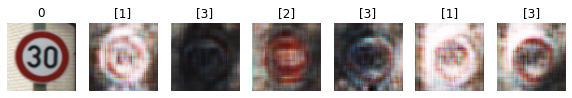

Epoch 3310 g_loss= 2.796871 d_loss= 0.07765301 real_acc= 1.0 fake_acc= 1.0
Epoch 3320 g_loss= 2.7117438 d_loss= 0.13246982 real_acc= 0.92 fake_acc= 1.0
Epoch 3330 g_loss= 2.3787196 d_loss= 0.08069789 real_acc= 1.0 fake_acc= 1.0
Epoch 3340 g_loss= 2.9970026 d_loss= 0.0733177 real_acc= 1.0 fake_acc= 1.0
Epoch 3350 g_loss= 3.358536 d_loss= 0.07174529 real_acc= 0.98 fake_acc= 1.0
Epoch 3360 g_loss= 3.7291577 d_loss= 0.083793595 real_acc= 0.94 fake_acc= 1.0
Epoch 3370 g_loss= 2.9283395 d_loss= 0.09038297 real_acc= 0.94 fake_acc= 1.0
Epoch 3380 g_loss= 3.044673 d_loss= 0.10721062 real_acc= 0.96 fake_acc= 0.98
Epoch 3390 g_loss= 2.8251586 d_loss= 0.088027805 real_acc= 0.98 fake_acc= 1.0
Epoch 3400 g_loss= 3.3621914 d_loss= 0.08347486 real_acc= 0.96 fake_acc= 1.0


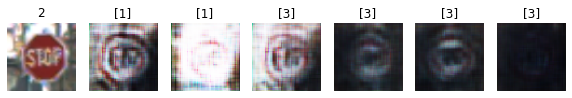

Epoch 3410 g_loss= 2.5555146 d_loss= 0.11535792 real_acc= 0.98 fake_acc= 0.98
Epoch 3420 g_loss= 3.0414147 d_loss= 0.072663784 real_acc= 1.0 fake_acc= 1.0
Epoch 3430 g_loss= 3.3764448 d_loss= 0.08793455 real_acc= 0.96 fake_acc= 1.0
Epoch 3440 g_loss= 4.134241 d_loss= 0.09982026 real_acc= 0.92 fake_acc= 1.0
Epoch 3450 g_loss= 2.3205914 d_loss= 0.11485797 real_acc= 0.96 fake_acc= 1.0
Epoch 3460 g_loss= 4.3476806 d_loss= 0.10819764 real_acc= 0.94 fake_acc= 1.0
Epoch 3470 g_loss= 4.007283 d_loss= 0.096955225 real_acc= 0.9 fake_acc= 1.0
Epoch 3480 g_loss= 2.7035913 d_loss= 0.09681727 real_acc= 0.98 fake_acc= 1.0
Epoch 3490 g_loss= 3.1465495 d_loss= 0.093150035 real_acc= 0.98 fake_acc= 1.0
Epoch 3500 g_loss= 2.9895847 d_loss= 0.07794087 real_acc= 1.0 fake_acc= 1.0


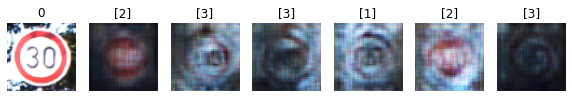

Epoch 3510 g_loss= 3.3367105 d_loss= 0.06951979 real_acc= 0.98 fake_acc= 1.0
Epoch 3520 g_loss= 3.131293 d_loss= 0.10221723 real_acc= 0.98 fake_acc= 1.0
Epoch 3530 g_loss= 2.8569045 d_loss= 0.09367227 real_acc= 0.96 fake_acc= 1.0
Epoch 3540 g_loss= 3.3370843 d_loss= 0.070373535 real_acc= 0.98 fake_acc= 1.0
Epoch 3550 g_loss= 3.9067109 d_loss= 0.052897394 real_acc= 0.98 fake_acc= 1.0
Epoch 3560 g_loss= 2.9379752 d_loss= 0.07895549 real_acc= 1.0 fake_acc= 1.0
Epoch 3570 g_loss= 3.750058 d_loss= 0.07691108 real_acc= 0.94 fake_acc= 1.0
Epoch 3580 g_loss= 2.873311 d_loss= 0.10313964 real_acc= 0.94 fake_acc= 1.0
Epoch 3590 g_loss= 2.7765424 d_loss= 0.09086859 real_acc= 0.96 fake_acc= 1.0
Epoch 3600 g_loss= 3.1975715 d_loss= 0.09202148 real_acc= 1.0 fake_acc= 1.0


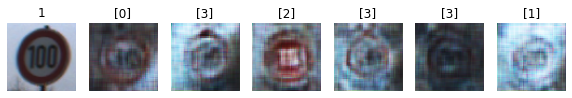

Epoch 3610 g_loss= 2.9554083 d_loss= 0.070588216 real_acc= 0.98 fake_acc= 1.0
Epoch 3620 g_loss= 3.57438 d_loss= 0.07308389 real_acc= 0.98 fake_acc= 1.0
Epoch 3630 g_loss= 3.79828 d_loss= 0.11457582 real_acc= 0.94 fake_acc= 1.0
Epoch 3640 g_loss= 3.2639153 d_loss= 0.060906906 real_acc= 0.98 fake_acc= 1.0
Epoch 3650 g_loss= 3.9615693 d_loss= 0.06045426 real_acc= 1.0 fake_acc= 1.0
Epoch 3660 g_loss= 3.418338 d_loss= 0.049038514 real_acc= 1.0 fake_acc= 1.0
Epoch 3670 g_loss= 2.8129482 d_loss= 0.08020358 real_acc= 0.96 fake_acc= 1.0
Epoch 3680 g_loss= 3.9631174 d_loss= 0.07309563 real_acc= 1.0 fake_acc= 1.0
Epoch 3690 g_loss= 4.200779 d_loss= 0.0455934 real_acc= 0.98 fake_acc= 1.0
Epoch 3700 g_loss= 3.981187 d_loss= 0.06868762 real_acc= 0.98 fake_acc= 1.0


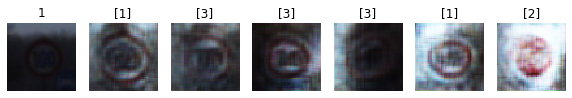

Epoch 3710 g_loss= 3.5387192 d_loss= 0.122195914 real_acc= 0.9 fake_acc= 1.0
Epoch 3720 g_loss= 2.9373865 d_loss= 0.07090667 real_acc= 0.98 fake_acc= 1.0
Epoch 3730 g_loss= 3.4139957 d_loss= 0.07485034 real_acc= 0.96 fake_acc= 1.0
Epoch 3740 g_loss= 3.6826448 d_loss= 0.04401245 real_acc= 1.0 fake_acc= 1.0
Epoch 3750 g_loss= 3.7088554 d_loss= 0.05641216 real_acc= 0.98 fake_acc= 1.0
Epoch 3760 g_loss= 3.7093863 d_loss= 0.034662336 real_acc= 1.0 fake_acc= 1.0
Epoch 3770 g_loss= 3.4624457 d_loss= 0.055435903 real_acc= 0.98 fake_acc= 1.0
Epoch 3780 g_loss= 3.9215229 d_loss= 0.056571897 real_acc= 1.0 fake_acc= 1.0
Epoch 3790 g_loss= 4.250387 d_loss= 0.058262363 real_acc= 0.98 fake_acc= 1.0
Epoch 3800 g_loss= 3.1237476 d_loss= 0.06695324 real_acc= 1.0 fake_acc= 1.0


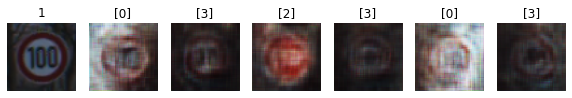

Epoch 3810 g_loss= 3.7311347 d_loss= 0.04714683 real_acc= 1.0 fake_acc= 1.0
Epoch 3820 g_loss= 3.2999234 d_loss= 0.0518054 real_acc= 1.0 fake_acc= 1.0
Epoch 3830 g_loss= 2.936757 d_loss= 0.056983616 real_acc= 1.0 fake_acc= 1.0
Epoch 3840 g_loss= 3.814413 d_loss= 0.08029609 real_acc= 0.96 fake_acc= 1.0
Epoch 3850 g_loss= 3.6180408 d_loss= 0.08325258 real_acc= 0.98 fake_acc= 1.0
Epoch 3860 g_loss= 2.7192426 d_loss= 0.08784544 real_acc= 0.98 fake_acc= 1.0
Epoch 3870 g_loss= 3.9382892 d_loss= 0.09760999 real_acc= 0.96 fake_acc= 1.0
Epoch 3880 g_loss= 3.5808265 d_loss= 0.055014588 real_acc= 0.98 fake_acc= 1.0
Epoch 3890 g_loss= 3.4460015 d_loss= 0.09443023 real_acc= 0.96 fake_acc= 1.0
Epoch 3900 g_loss= 4.22643 d_loss= 0.07959269 real_acc= 0.96 fake_acc= 1.0


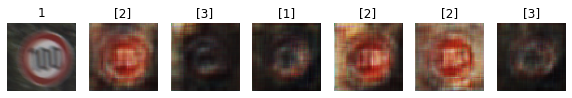

Epoch 3910 g_loss= 4.505914 d_loss= 0.05334653 real_acc= 0.96 fake_acc= 1.0
Epoch 3920 g_loss= 3.3595514 d_loss= 0.0942557 real_acc= 0.96 fake_acc= 1.0
Epoch 3930 g_loss= 3.4038074 d_loss= 0.047851518 real_acc= 0.98 fake_acc= 1.0
Epoch 3940 g_loss= 3.5882251 d_loss= 0.069552094 real_acc= 0.96 fake_acc= 1.0
Epoch 3950 g_loss= 4.1676836 d_loss= 0.049956217 real_acc= 0.98 fake_acc= 1.0
Epoch 3960 g_loss= 3.9048164 d_loss= 0.05126068 real_acc= 1.0 fake_acc= 1.0
Epoch 3970 g_loss= 3.408568 d_loss= 0.06591208 real_acc= 0.98 fake_acc= 1.0
Epoch 3980 g_loss= 3.41935 d_loss= 0.06385361 real_acc= 0.98 fake_acc= 1.0
Epoch 3990 g_loss= 3.376914 d_loss= 0.08701928 real_acc= 0.94 fake_acc= 1.0
Epoch 4000 g_loss= 3.1752038 d_loss= 0.085394435 real_acc= 0.96 fake_acc= 1.0


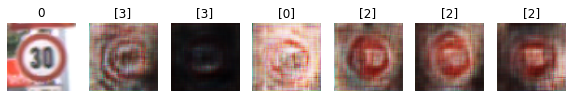

Epoch 4010 g_loss= 3.0613468 d_loss= 0.08432461 real_acc= 0.98 fake_acc= 1.0
Epoch 4020 g_loss= 3.5565064 d_loss= 0.06742672 real_acc= 0.98 fake_acc= 1.0
Epoch 4030 g_loss= 3.7142909 d_loss= 0.078807786 real_acc= 0.96 fake_acc= 1.0
Epoch 4040 g_loss= 4.3341475 d_loss= 0.043846972 real_acc= 1.0 fake_acc= 1.0
Epoch 4050 g_loss= 4.0553 d_loss= 0.083425276 real_acc= 0.94 fake_acc= 1.0
Epoch 4060 g_loss= 3.6335332 d_loss= 0.07178174 real_acc= 0.96 fake_acc= 1.0
Epoch 4070 g_loss= 3.8783343 d_loss= 0.056361526 real_acc= 0.96 fake_acc= 1.0
Epoch 4080 g_loss= 2.8533332 d_loss= 0.06894602 real_acc= 1.0 fake_acc= 1.0
Epoch 4090 g_loss= 3.9126008 d_loss= 0.06588765 real_acc= 0.96 fake_acc= 1.0
Epoch 4100 g_loss= 4.9055576 d_loss= 0.07188368 real_acc= 0.96 fake_acc= 1.0


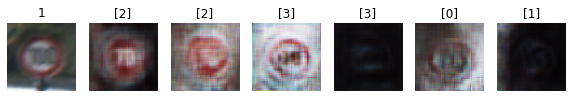

Epoch 4110 g_loss= 4.2696424 d_loss= 0.09639797 real_acc= 0.94 fake_acc= 1.0
Epoch 4120 g_loss= 3.8073902 d_loss= 0.058421843 real_acc= 0.98 fake_acc= 1.0
Epoch 4130 g_loss= 3.9296212 d_loss= 0.057128705 real_acc= 0.96 fake_acc= 1.0
Epoch 4140 g_loss= 3.518645 d_loss= 0.06548568 real_acc= 0.96 fake_acc= 1.0
Epoch 4150 g_loss= 3.7528977 d_loss= 0.075021535 real_acc= 0.96 fake_acc= 1.0
Epoch 4160 g_loss= 3.369735 d_loss= 0.049118944 real_acc= 1.0 fake_acc= 1.0
Epoch 4170 g_loss= 3.7286618 d_loss= 0.058061417 real_acc= 0.98 fake_acc= 1.0
Epoch 4180 g_loss= 3.7640033 d_loss= 0.03369251 real_acc= 1.0 fake_acc= 1.0
Epoch 4190 g_loss= 3.8428378 d_loss= 0.072201766 real_acc= 0.94 fake_acc= 1.0
Epoch 4200 g_loss= 3.9522533 d_loss= 0.031676203 real_acc= 1.0 fake_acc= 1.0


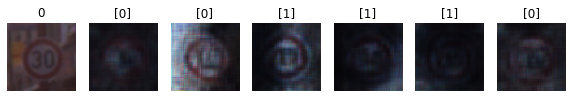

Epoch 4210 g_loss= 4.099598 d_loss= 0.060815178 real_acc= 0.94 fake_acc= 1.0
Epoch 4220 g_loss= 3.1509397 d_loss= 0.07737477 real_acc= 0.96 fake_acc= 1.0
Epoch 4230 g_loss= 2.4450755 d_loss= 0.08948691 real_acc= 1.0 fake_acc= 1.0
Epoch 4240 g_loss= 3.2750738 d_loss= 0.06396392 real_acc= 0.98 fake_acc= 1.0
Epoch 4250 g_loss= 3.9548767 d_loss= 0.053218424 real_acc= 0.96 fake_acc= 1.0
Epoch 4260 g_loss= 2.912636 d_loss= 0.08370693 real_acc= 0.96 fake_acc= 1.0
Epoch 4270 g_loss= 2.991078 d_loss= 0.039319158 real_acc= 1.0 fake_acc= 1.0
Epoch 4280 g_loss= 3.1436048 d_loss= 0.04097236 real_acc= 1.0 fake_acc= 1.0
Epoch 4290 g_loss= 3.0729008 d_loss= 0.061714083 real_acc= 1.0 fake_acc= 1.0
Epoch 4300 g_loss= 3.2395184 d_loss= 0.070701465 real_acc= 0.96 fake_acc= 1.0


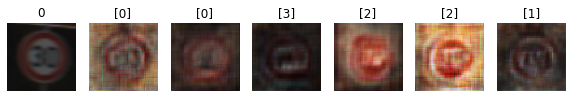

Epoch 4310 g_loss= 4.610705 d_loss= 0.05658659 real_acc= 0.98 fake_acc= 1.0
Epoch 4320 g_loss= 4.4117546 d_loss= 0.026624557 real_acc= 1.0 fake_acc= 1.0
Epoch 4330 g_loss= 4.164173 d_loss= 0.057338342 real_acc= 0.94 fake_acc= 1.0
Epoch 4340 g_loss= 2.9148645 d_loss= 0.05603802 real_acc= 1.0 fake_acc= 1.0
Epoch 4350 g_loss= 3.205924 d_loss= 0.050510187 real_acc= 0.98 fake_acc= 1.0
Epoch 4360 g_loss= 4.164958 d_loss= 0.035717357 real_acc= 1.0 fake_acc= 1.0
Epoch 4370 g_loss= 4.0217 d_loss= 0.04576163 real_acc= 1.0 fake_acc= 1.0
Epoch 4380 g_loss= 3.737948 d_loss= 0.043095954 real_acc= 0.98 fake_acc= 1.0
Epoch 4390 g_loss= 4.6032047 d_loss= 0.031187128 real_acc= 1.0 fake_acc= 1.0
Epoch 4400 g_loss= 4.7075405 d_loss= 0.05160763 real_acc= 0.96 fake_acc= 1.0


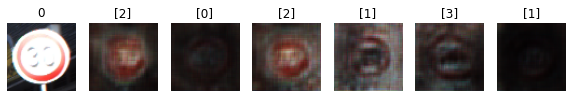

Epoch 4410 g_loss= 3.7386847 d_loss= 0.03582488 real_acc= 1.0 fake_acc= 1.0
Epoch 4420 g_loss= 3.3813262 d_loss= 0.0929409 real_acc= 0.96 fake_acc= 1.0
Epoch 4430 g_loss= 4.4491134 d_loss= 0.05889527 real_acc= 0.98 fake_acc= 1.0
Epoch 4440 g_loss= 3.8258505 d_loss= 0.0430687 real_acc= 0.98 fake_acc= 1.0
Epoch 4450 g_loss= 3.977365 d_loss= 0.050933994 real_acc= 0.98 fake_acc= 1.0
Epoch 4460 g_loss= 4.1453886 d_loss= 0.02994284 real_acc= 1.0 fake_acc= 1.0
Epoch 4470 g_loss= 4.8192797 d_loss= 0.047535703 real_acc= 0.98 fake_acc= 1.0
Epoch 4480 g_loss= 4.188204 d_loss= 0.037419744 real_acc= 1.0 fake_acc= 1.0
Epoch 4490 g_loss= 3.7965915 d_loss= 0.03167565 real_acc= 1.0 fake_acc= 1.0
Epoch 4500 g_loss= 4.171211 d_loss= 0.032369245 real_acc= 0.98 fake_acc= 1.0


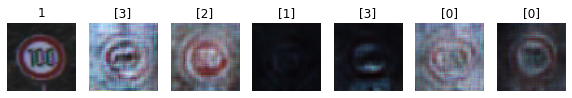

Epoch 4510 g_loss= 3.882882 d_loss= 0.044668324 real_acc= 0.98 fake_acc= 1.0
Epoch 4520 g_loss= 4.7937484 d_loss= 0.030657684 real_acc= 1.0 fake_acc= 1.0
Epoch 4530 g_loss= 3.5427833 d_loss= 0.03974934 real_acc= 1.0 fake_acc= 1.0
Epoch 4540 g_loss= 4.464003 d_loss= 0.029575506 real_acc= 1.0 fake_acc= 1.0
Epoch 4550 g_loss= 5.2018394 d_loss= 0.0498098 real_acc= 0.96 fake_acc= 1.0
Epoch 4560 g_loss= 4.1320906 d_loss= 0.034403827 real_acc= 0.98 fake_acc= 1.0
Epoch 4570 g_loss= 4.6538634 d_loss= 0.09923554 real_acc= 0.9 fake_acc= 1.0
Epoch 4580 g_loss= 3.9521034 d_loss= 0.058404267 real_acc= 1.0 fake_acc= 1.0
Epoch 4590 g_loss= 4.71759 d_loss= 0.049044654 real_acc= 0.96 fake_acc= 1.0
Epoch 4600 g_loss= 4.247746 d_loss= 0.030538391 real_acc= 1.0 fake_acc= 1.0


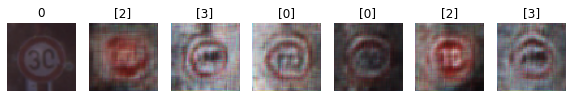

Epoch 4610 g_loss= 3.8815436 d_loss= 0.046665944 real_acc= 0.96 fake_acc= 1.0
Epoch 4620 g_loss= 4.2707973 d_loss= 0.057039954 real_acc= 0.96 fake_acc= 1.0
Epoch 4630 g_loss= 4.1706233 d_loss= 0.047558527 real_acc= 0.98 fake_acc= 1.0
Epoch 4640 g_loss= 3.856211 d_loss= 0.04781472 real_acc= 0.96 fake_acc= 1.0
Epoch 4650 g_loss= 3.247659 d_loss= 0.075823724 real_acc= 0.98 fake_acc= 1.0
Epoch 4660 g_loss= 3.1549048 d_loss= 0.041392665 real_acc= 1.0 fake_acc= 1.0
Epoch 4670 g_loss= 3.4919767 d_loss= 0.03822626 real_acc= 1.0 fake_acc= 1.0
Epoch 4680 g_loss= 3.4605377 d_loss= 0.06293652 real_acc= 0.96 fake_acc= 1.0
Epoch 4690 g_loss= 3.4259217 d_loss= 0.058061175 real_acc= 0.98 fake_acc= 1.0
Epoch 4700 g_loss= 3.4463928 d_loss= 0.0448218 real_acc= 1.0 fake_acc= 1.0


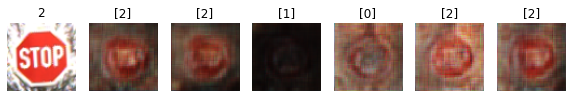

Epoch 4710 g_loss= 4.181054 d_loss= 0.036751777 real_acc= 1.0 fake_acc= 1.0
Epoch 4720 g_loss= 4.134967 d_loss= 0.057421178 real_acc= 0.98 fake_acc= 1.0
Epoch 4730 g_loss= 3.3212934 d_loss= 0.069765046 real_acc= 0.96 fake_acc= 1.0
Epoch 4740 g_loss= 3.7278423 d_loss= 0.06365481 real_acc= 0.96 fake_acc= 1.0
Epoch 4750 g_loss= 4.2624974 d_loss= 0.05448647 real_acc= 0.96 fake_acc= 1.0
Epoch 4760 g_loss= 3.2274718 d_loss= 0.040206313 real_acc= 1.0 fake_acc= 1.0
Epoch 4770 g_loss= 3.8606434 d_loss= 0.060147986 real_acc= 0.96 fake_acc= 1.0
Epoch 4780 g_loss= 4.1640835 d_loss= 0.027022213 real_acc= 1.0 fake_acc= 1.0
Epoch 4790 g_loss= 4.3655334 d_loss= 0.04346575 real_acc= 0.98 fake_acc= 1.0
Epoch 4800 g_loss= 3.8671567 d_loss= 0.03266578 real_acc= 1.0 fake_acc= 1.0


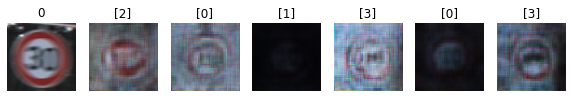

Epoch 4810 g_loss= 3.8430183 d_loss= 0.05142951 real_acc= 0.98 fake_acc= 1.0
Epoch 4820 g_loss= 3.6705236 d_loss= 0.050401326 real_acc= 1.0 fake_acc= 1.0
Epoch 4830 g_loss= 3.4802308 d_loss= 0.04894845 real_acc= 0.96 fake_acc= 1.0
Epoch 4840 g_loss= 3.6705518 d_loss= 0.04125414 real_acc= 0.98 fake_acc= 1.0
Epoch 4850 g_loss= 3.8142133 d_loss= 0.048913382 real_acc= 0.96 fake_acc= 1.0
Epoch 4860 g_loss= 4.124981 d_loss= 0.035477012 real_acc= 1.0 fake_acc= 1.0
Epoch 4870 g_loss= 3.7140746 d_loss= 0.032690655 real_acc= 1.0 fake_acc= 1.0
Epoch 4880 g_loss= 3.0673556 d_loss= 0.051687002 real_acc= 0.98 fake_acc= 1.0
Epoch 4890 g_loss= 3.123299 d_loss= 0.03489306 real_acc= 1.0 fake_acc= 1.0
Epoch 4900 g_loss= 3.243979 d_loss= 0.04724898 real_acc= 0.98 fake_acc= 1.0


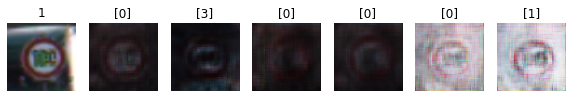

Epoch 4910 g_loss= 2.7244837 d_loss= 0.06182393 real_acc= 1.0 fake_acc= 1.0
Epoch 4920 g_loss= 2.6996398 d_loss= 0.06835188 real_acc= 0.98 fake_acc= 1.0
Epoch 4930 g_loss= 2.912566 d_loss= 0.046131913 real_acc= 1.0 fake_acc= 1.0
Epoch 4940 g_loss= 3.2140195 d_loss= 0.031282872 real_acc= 1.0 fake_acc= 1.0
Epoch 4950 g_loss= 2.848745 d_loss= 0.05907102 real_acc= 1.0 fake_acc= 1.0
Epoch 4960 g_loss= 3.3628368 d_loss= 0.054538574 real_acc= 0.98 fake_acc= 1.0
Epoch 4970 g_loss= 2.8324914 d_loss= 0.052471254 real_acc= 1.0 fake_acc= 1.0
Epoch 4980 g_loss= 3.6446917 d_loss= 0.049363136 real_acc= 0.96 fake_acc= 1.0
Epoch 4990 g_loss= 3.6765575 d_loss= 0.027791739 real_acc= 1.0 fake_acc= 1.0
Epoch 5000 g_loss= 4.372947 d_loss= 0.014546718 real_acc= 1.0 fake_acc= 1.0


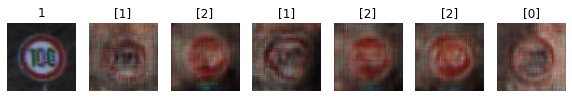

Epoch 5010 g_loss= 3.6185791 d_loss= 0.03912291 real_acc= 0.98 fake_acc= 1.0
Epoch 5020 g_loss= 3.485835 d_loss= 0.040979587 real_acc= 0.98 fake_acc= 1.0
Epoch 5030 g_loss= 4.160009 d_loss= 0.025012592 real_acc= 1.0 fake_acc= 1.0
Epoch 5040 g_loss= 3.9524634 d_loss= 0.02993386 real_acc= 1.0 fake_acc= 1.0
Epoch 5050 g_loss= 4.3668365 d_loss= 0.028224193 real_acc= 1.0 fake_acc= 1.0
Epoch 5060 g_loss= 4.9644823 d_loss= 0.02493092 real_acc= 0.98 fake_acc= 1.0
Epoch 5070 g_loss= 4.160013 d_loss= 0.043424547 real_acc= 0.96 fake_acc= 1.0
Epoch 5080 g_loss= 3.7509289 d_loss= 0.048614874 real_acc= 0.96 fake_acc= 1.0
Epoch 5090 g_loss= 3.9716346 d_loss= 0.029836688 real_acc= 1.0 fake_acc= 1.0
Epoch 5100 g_loss= 3.463073 d_loss= 0.045948885 real_acc= 1.0 fake_acc= 1.0


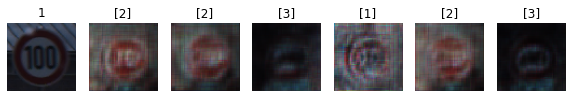

Epoch 5110 g_loss= 3.9078612 d_loss= 0.04106928 real_acc= 0.98 fake_acc= 1.0
Epoch 5120 g_loss= 3.7976706 d_loss= 0.021764131 real_acc= 1.0 fake_acc= 1.0
Epoch 5130 g_loss= 3.7152631 d_loss= 0.021356829 real_acc= 1.0 fake_acc= 1.0
Epoch 5140 g_loss= 3.2178357 d_loss= 0.04646492 real_acc= 0.98 fake_acc= 1.0
Epoch 5150 g_loss= 3.8182416 d_loss= 0.040801942 real_acc= 0.98 fake_acc= 1.0
Epoch 5160 g_loss= 3.2588003 d_loss= 0.04235761 real_acc= 1.0 fake_acc= 1.0
Epoch 5170 g_loss= 4.028649 d_loss= 0.036604047 real_acc= 1.0 fake_acc= 1.0
Epoch 5180 g_loss= 3.277844 d_loss= 0.045565628 real_acc= 1.0 fake_acc= 1.0
Epoch 5190 g_loss= 3.7094052 d_loss= 0.05442339 real_acc= 0.98 fake_acc= 1.0
Epoch 5200 g_loss= 3.6875472 d_loss= 0.023991935 real_acc= 1.0 fake_acc= 1.0


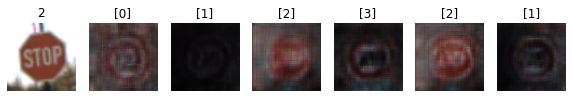

Epoch 5210 g_loss= 3.3624732 d_loss= 0.029204726 real_acc= 1.0 fake_acc= 1.0
Epoch 5220 g_loss= 4.061372 d_loss= 0.01900235 real_acc= 1.0 fake_acc= 1.0
Epoch 5230 g_loss= 4.099371 d_loss= 0.031136742 real_acc= 0.98 fake_acc= 1.0
Epoch 5240 g_loss= 3.9045062 d_loss= 0.025805794 real_acc= 1.0 fake_acc= 1.0
Epoch 5250 g_loss= 3.7026105 d_loss= 0.022112593 real_acc= 1.0 fake_acc= 1.0
Epoch 5260 g_loss= 2.8836792 d_loss= 0.0520355 real_acc= 1.0 fake_acc= 1.0
Epoch 5270 g_loss= 3.7511168 d_loss= 0.04216368 real_acc= 0.98 fake_acc= 1.0
Epoch 5280 g_loss= 4.0499096 d_loss= 0.025502812 real_acc= 1.0 fake_acc= 1.0
Epoch 5290 g_loss= 4.2081237 d_loss= 0.01933911 real_acc= 1.0 fake_acc= 1.0
Epoch 5300 g_loss= 4.134593 d_loss= 0.03325392 real_acc= 1.0 fake_acc= 1.0


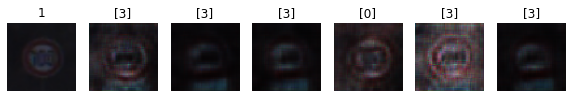

Epoch 5310 g_loss= 3.8032305 d_loss= 0.04143133 real_acc= 0.98 fake_acc= 1.0
Epoch 5320 g_loss= 3.684822 d_loss= 0.032172266 real_acc= 0.98 fake_acc= 1.0
Epoch 5330 g_loss= 3.516041 d_loss= 0.043204293 real_acc= 1.0 fake_acc= 1.0
Epoch 5340 g_loss= 3.570928 d_loss= 0.03324522 real_acc= 0.98 fake_acc= 1.0
Epoch 5350 g_loss= 3.7329316 d_loss= 0.03946056 real_acc= 0.98 fake_acc= 1.0
Epoch 5360 g_loss= 4.5181813 d_loss= 0.0427778 real_acc= 0.98 fake_acc= 1.0
Epoch 5370 g_loss= 4.5298743 d_loss= 0.053405825 real_acc= 0.96 fake_acc= 1.0
Epoch 5380 g_loss= 4.572935 d_loss= 0.022961147 real_acc= 1.0 fake_acc= 1.0
Epoch 5390 g_loss= 4.764239 d_loss= 0.04102914 real_acc= 0.98 fake_acc= 1.0
Epoch 5400 g_loss= 4.746468 d_loss= 0.01634708 real_acc= 1.0 fake_acc= 1.0


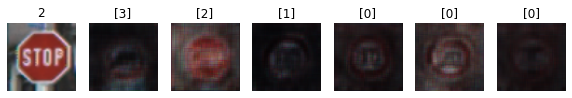

Epoch 5410 g_loss= 4.54869 d_loss= 0.027664993 real_acc= 0.98 fake_acc= 1.0
Epoch 5420 g_loss= 4.076253 d_loss= 0.04522044 real_acc= 0.96 fake_acc= 1.0
Epoch 5430 g_loss= 4.5534544 d_loss= 0.03453362 real_acc= 0.96 fake_acc= 1.0
Epoch 5440 g_loss= 4.900537 d_loss= 0.041505817 real_acc= 0.98 fake_acc= 1.0
Epoch 5450 g_loss= 4.4776845 d_loss= 0.021683998 real_acc= 0.98 fake_acc= 1.0
Epoch 5460 g_loss= 4.1241775 d_loss= 0.024772659 real_acc= 0.98 fake_acc= 1.0
Epoch 5470 g_loss= 4.8156624 d_loss= 0.0346246 real_acc= 0.96 fake_acc= 1.0
Epoch 5480 g_loss= 3.7147405 d_loss= 0.035994764 real_acc= 0.96 fake_acc= 1.0
Epoch 5490 g_loss= 3.0002842 d_loss= 0.05652035 real_acc= 0.98 fake_acc= 1.0
Epoch 5500 g_loss= 3.672301 d_loss= 0.034595843 real_acc= 1.0 fake_acc= 1.0


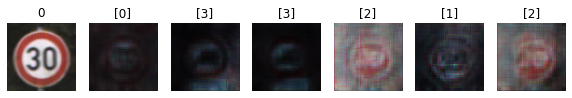

Epoch 5510 g_loss= 3.1262434 d_loss= 0.03702882 real_acc= 1.0 fake_acc= 1.0
Epoch 5520 g_loss= 3.8488111 d_loss= 0.030827854 real_acc= 0.98 fake_acc= 1.0
Epoch 5530 g_loss= 3.4037478 d_loss= 0.02975155 real_acc= 1.0 fake_acc= 1.0
Epoch 5540 g_loss= 3.3895571 d_loss= 0.028087322 real_acc= 1.0 fake_acc= 1.0
Epoch 5550 g_loss= 3.5700498 d_loss= 0.02527744 real_acc= 1.0 fake_acc= 1.0
Epoch 5560 g_loss= 4.97334 d_loss= 0.039995354 real_acc= 0.98 fake_acc= 1.0
Epoch 5570 g_loss= 5.113656 d_loss= 0.029626999 real_acc= 0.96 fake_acc= 1.0
Epoch 5580 g_loss= 5.644716 d_loss= 0.024858147 real_acc= 0.98 fake_acc= 1.0
Epoch 5590 g_loss= 4.921148 d_loss= 0.05837089 real_acc= 0.96 fake_acc= 1.0
Epoch 5600 g_loss= 4.506454 d_loss= 0.09199844 real_acc= 0.96 fake_acc= 1.0


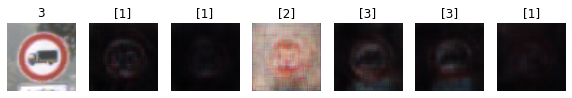

Epoch 5610 g_loss= 3.330865 d_loss= 0.028430048 real_acc= 1.0 fake_acc= 1.0
Epoch 5620 g_loss= 5.0644283 d_loss= 0.02408254 real_acc= 1.0 fake_acc= 1.0
Epoch 5630 g_loss= 4.6288915 d_loss= 0.019596098 real_acc= 1.0 fake_acc= 1.0
Epoch 5640 g_loss= 3.784826 d_loss= 0.032703854 real_acc= 1.0 fake_acc= 1.0
Epoch 5650 g_loss= 3.5184739 d_loss= 0.04085633 real_acc= 1.0 fake_acc= 1.0
Epoch 5660 g_loss= 4.7916503 d_loss= 0.021164868 real_acc= 0.98 fake_acc= 1.0
Epoch 5670 g_loss= 4.4065886 d_loss= 0.023787737 real_acc= 1.0 fake_acc= 1.0
Epoch 5680 g_loss= 4.1534276 d_loss= 0.027287118 real_acc= 0.98 fake_acc= 1.0
Epoch 5690 g_loss= 4.5541306 d_loss= 0.02068749 real_acc= 1.0 fake_acc= 1.0
Epoch 5700 g_loss= 4.818409 d_loss= 0.010232668 real_acc= 1.0 fake_acc= 1.0


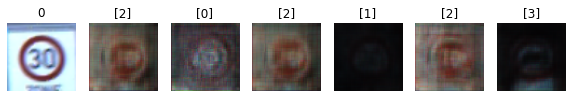

Epoch 5710 g_loss= 4.497958 d_loss= 0.0183295 real_acc= 1.0 fake_acc= 1.0
Epoch 5720 g_loss= 3.4889627 d_loss= 0.027493706 real_acc= 1.0 fake_acc= 1.0
Epoch 5730 g_loss= 4.6674504 d_loss= 0.020488676 real_acc= 1.0 fake_acc= 1.0
Epoch 5740 g_loss= 4.4449787 d_loss= 0.027106259 real_acc= 0.98 fake_acc= 1.0
Epoch 5750 g_loss= 4.5018373 d_loss= 0.022043366 real_acc= 1.0 fake_acc= 1.0
Epoch 5760 g_loss= 4.418009 d_loss= 0.026254987 real_acc= 0.98 fake_acc= 1.0
Epoch 5770 g_loss= 4.7693157 d_loss= 0.028559096 real_acc= 0.98 fake_acc= 1.0
Epoch 5780 g_loss= 3.8120446 d_loss= 0.028854338 real_acc= 0.98 fake_acc= 1.0
Epoch 5790 g_loss= 3.7287915 d_loss= 0.0278293 real_acc= 1.0 fake_acc= 1.0
Epoch 5800 g_loss= 3.9161162 d_loss= 0.040305078 real_acc= 0.98 fake_acc= 1.0


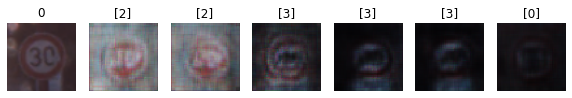

Epoch 5810 g_loss= 3.5373614 d_loss= 0.029185016 real_acc= 1.0 fake_acc= 1.0
Epoch 5820 g_loss= 3.5329363 d_loss= 0.028364267 real_acc= 1.0 fake_acc= 1.0
Epoch 5830 g_loss= 2.739529 d_loss= 0.055918887 real_acc= 1.0 fake_acc= 1.0
Epoch 5840 g_loss= 3.3758972 d_loss= 0.030568076 real_acc= 1.0 fake_acc= 1.0
Epoch 5850 g_loss= 4.3543367 d_loss= 0.052195743 real_acc= 0.96 fake_acc= 1.0
Epoch 5860 g_loss= 4.637115 d_loss= 0.04022476 real_acc= 0.96 fake_acc= 1.0
Epoch 5870 g_loss= 4.396536 d_loss= 0.021409862 real_acc= 1.0 fake_acc= 1.0
Epoch 5880 g_loss= 4.910678 d_loss= 0.037507884 real_acc= 0.96 fake_acc= 1.0
Epoch 5890 g_loss= 4.124458 d_loss= 0.016016696 real_acc= 1.0 fake_acc= 1.0
Epoch 5900 g_loss= 4.1090484 d_loss= 0.02977503 real_acc= 1.0 fake_acc= 1.0


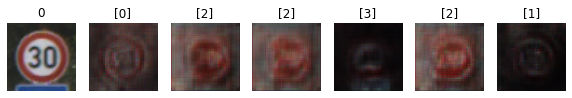

Epoch 5910 g_loss= 4.2392516 d_loss= 0.023454519 real_acc= 1.0 fake_acc= 1.0
Epoch 5920 g_loss= 4.486999 d_loss= 0.026322305 real_acc= 1.0 fake_acc= 1.0
Epoch 5930 g_loss= 4.387085 d_loss= 0.013764811 real_acc= 1.0 fake_acc= 1.0
Epoch 5940 g_loss= 4.144624 d_loss= 0.017730854 real_acc= 1.0 fake_acc= 1.0
Epoch 5950 g_loss= 4.6580577 d_loss= 0.013706305 real_acc= 1.0 fake_acc= 1.0
Epoch 5960 g_loss= 4.682403 d_loss= 0.01866413 real_acc= 1.0 fake_acc= 1.0
Epoch 5970 g_loss= 4.551309 d_loss= 0.042855702 real_acc= 0.96 fake_acc= 1.0
Epoch 5980 g_loss= 4.7389445 d_loss= 0.012620726 real_acc= 1.0 fake_acc= 1.0
Epoch 5990 g_loss= 3.4495907 d_loss= 0.024847003 real_acc= 1.0 fake_acc= 1.0
Epoch 6000 g_loss= 4.5429144 d_loss= 0.06422112 real_acc= 0.96 fake_acc= 1.0


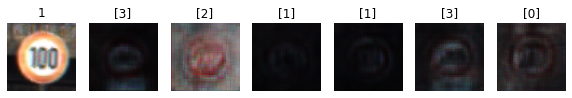

Epoch 6010 g_loss= 5.2385097 d_loss= 0.020903274 real_acc= 1.0 fake_acc= 1.0
Epoch 6020 g_loss= 4.3978376 d_loss= 0.04417914 real_acc= 0.96 fake_acc= 1.0
Epoch 6030 g_loss= 4.769956 d_loss= 0.05131772 real_acc= 0.96 fake_acc= 1.0
Epoch 6040 g_loss= 5.1075053 d_loss= 0.016991265 real_acc= 1.0 fake_acc= 1.0
Epoch 6050 g_loss= 4.1988945 d_loss= 0.046419136 real_acc= 0.96 fake_acc= 1.0
Epoch 6060 g_loss= 5.269737 d_loss= 0.009308677 real_acc= 1.0 fake_acc= 1.0
Epoch 6070 g_loss= 4.8293276 d_loss= 0.013000088 real_acc= 1.0 fake_acc= 1.0
Epoch 6080 g_loss= 4.402815 d_loss= 0.022691995 real_acc= 1.0 fake_acc= 1.0
Epoch 6090 g_loss= 3.8778777 d_loss= 0.035108514 real_acc= 0.96 fake_acc= 1.0
Epoch 6100 g_loss= 4.61865 d_loss= 0.02405493 real_acc= 0.98 fake_acc= 1.0


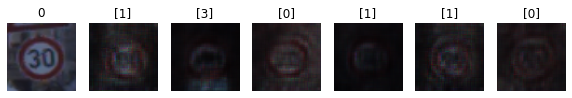

Epoch 6110 g_loss= 5.103607 d_loss= 0.026781349 real_acc= 0.98 fake_acc= 1.0
Epoch 6120 g_loss= 5.1190014 d_loss= 0.015338216 real_acc= 0.98 fake_acc= 1.0
Epoch 6130 g_loss= 4.6358995 d_loss= 0.008941552 real_acc= 1.0 fake_acc= 1.0
Epoch 6140 g_loss= 4.124292 d_loss= 0.015034344 real_acc= 1.0 fake_acc= 1.0
Epoch 6150 g_loss= 4.53761 d_loss= 0.025742244 real_acc= 0.98 fake_acc= 1.0
Epoch 6160 g_loss= 4.093096 d_loss= 0.022807788 real_acc= 1.0 fake_acc= 1.0
Epoch 6170 g_loss= 4.5204034 d_loss= 0.015660696 real_acc= 1.0 fake_acc= 1.0
Epoch 6180 g_loss= 4.1051846 d_loss= 0.02358672 real_acc= 1.0 fake_acc= 1.0
Epoch 6190 g_loss= 4.132767 d_loss= 0.016946636 real_acc= 1.0 fake_acc= 1.0
Epoch 6200 g_loss= 4.5534306 d_loss= 0.022827912 real_acc= 1.0 fake_acc= 1.0


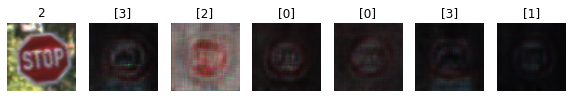

Epoch 6210 g_loss= 4.3817515 d_loss= 0.016306099 real_acc= 1.0 fake_acc= 1.0
Epoch 6220 g_loss= 5.160806 d_loss= 0.029910902 real_acc= 0.98 fake_acc= 1.0
Epoch 6230 g_loss= 5.301989 d_loss= 0.024882754 real_acc= 0.98 fake_acc= 1.0
Epoch 6240 g_loss= 4.7241564 d_loss= 0.035291225 real_acc= 0.98 fake_acc= 1.0
Epoch 6250 g_loss= 4.592933 d_loss= 0.03187282 real_acc= 0.98 fake_acc= 1.0
Epoch 6260 g_loss= 5.0574827 d_loss= 0.019348225 real_acc= 1.0 fake_acc= 1.0
Epoch 6270 g_loss= 5.2693286 d_loss= 0.023725227 real_acc= 0.98 fake_acc= 1.0
Epoch 6280 g_loss= 4.928084 d_loss= 0.026010383 real_acc= 0.96 fake_acc= 1.0
Epoch 6290 g_loss= 4.5454755 d_loss= 0.008432718 real_acc= 1.0 fake_acc= 1.0
Epoch 6300 g_loss= 4.9498725 d_loss= 0.020899039 real_acc= 0.98 fake_acc= 1.0


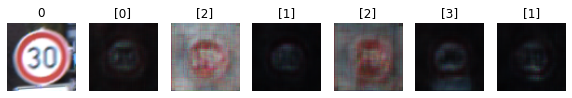

Epoch 6310 g_loss= 5.0682015 d_loss= 0.014633747 real_acc= 1.0 fake_acc= 1.0
Epoch 6320 g_loss= 4.3609757 d_loss= 0.022107072 real_acc= 1.0 fake_acc= 1.0
Epoch 6330 g_loss= 4.5398946 d_loss= 0.03643319 real_acc= 0.96 fake_acc= 1.0
Epoch 6340 g_loss= 5.7268395 d_loss= 0.01430457 real_acc= 1.0 fake_acc= 1.0
Epoch 6350 g_loss= 4.796799 d_loss= 0.0117316805 real_acc= 1.0 fake_acc= 1.0
Epoch 6360 g_loss= 4.433457 d_loss= 0.01918146 real_acc= 1.0 fake_acc= 1.0
Epoch 6370 g_loss= 4.828407 d_loss= 0.01254894 real_acc= 1.0 fake_acc= 1.0
Epoch 6380 g_loss= 4.1291413 d_loss= 0.023284104 real_acc= 1.0 fake_acc= 1.0
Epoch 6390 g_loss= 4.243904 d_loss= 0.01965492 real_acc= 1.0 fake_acc= 1.0
Epoch 6400 g_loss= 4.3991017 d_loss= 0.011367487 real_acc= 1.0 fake_acc= 1.0


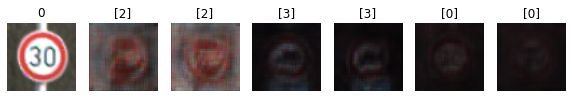

Epoch 6410 g_loss= 5.4700494 d_loss= 0.006930336 real_acc= 1.0 fake_acc= 1.0
Epoch 6420 g_loss= 4.5699825 d_loss= 0.014747668 real_acc= 1.0 fake_acc= 1.0
Epoch 6430 g_loss= 4.6251025 d_loss= 0.01209496 real_acc= 1.0 fake_acc= 1.0
Epoch 6440 g_loss= 4.6466484 d_loss= 0.017203484 real_acc= 1.0 fake_acc= 1.0
Epoch 6450 g_loss= 5.162229 d_loss= 0.01945555 real_acc= 0.98 fake_acc= 1.0
Epoch 6460 g_loss= 5.2327666 d_loss= 0.020056687 real_acc= 0.98 fake_acc= 1.0
Epoch 6470 g_loss= 3.7586854 d_loss= 0.028152112 real_acc= 1.0 fake_acc= 1.0
Epoch 6480 g_loss= 5.4205565 d_loss= 0.02371228 real_acc= 0.98 fake_acc= 1.0
Epoch 6490 g_loss= 5.49568 d_loss= 0.0160718 real_acc= 1.0 fake_acc= 1.0
Epoch 6500 g_loss= 4.2363467 d_loss= 0.024521634 real_acc= 1.0 fake_acc= 1.0


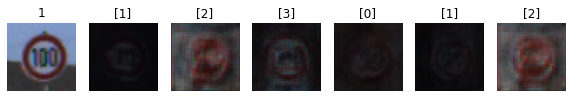

Epoch 6510 g_loss= 4.3543167 d_loss= 0.018917073 real_acc= 1.0 fake_acc= 1.0
Epoch 6520 g_loss= 4.9324846 d_loss= 0.021601215 real_acc= 0.98 fake_acc= 1.0
Epoch 6530 g_loss= 6.297198 d_loss= 0.015035534 real_acc= 0.98 fake_acc= 1.0
Epoch 6540 g_loss= 5.417625 d_loss= 0.027996078 real_acc= 0.96 fake_acc= 1.0
Epoch 6550 g_loss= 5.0323725 d_loss= 0.016983569 real_acc= 1.0 fake_acc= 1.0
Epoch 6560 g_loss= 5.385537 d_loss= 0.012371793 real_acc= 1.0 fake_acc= 1.0
Epoch 6570 g_loss= 4.020164 d_loss= 0.01370957 real_acc= 1.0 fake_acc= 1.0
Epoch 6580 g_loss= 4.6795783 d_loss= 0.018154219 real_acc= 0.98 fake_acc= 1.0
Epoch 6590 g_loss= 5.6393676 d_loss= 0.00579337 real_acc= 1.0 fake_acc= 1.0
Epoch 6600 g_loss= 5.353209 d_loss= 0.009520927 real_acc= 1.0 fake_acc= 1.0


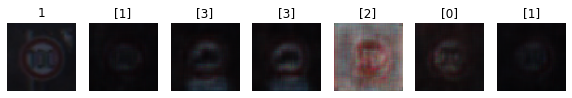

Epoch 6610 g_loss= 3.7558002 d_loss= 0.023667142 real_acc= 1.0 fake_acc= 1.0
Epoch 6620 g_loss= 5.650559 d_loss= 0.026224237 real_acc= 0.98 fake_acc= 1.0
Epoch 6630 g_loss= 6.1964345 d_loss= 0.028145837 real_acc= 0.98 fake_acc= 1.0
Epoch 6640 g_loss= 4.9333906 d_loss= 0.015640585 real_acc= 1.0 fake_acc= 1.0
Epoch 6650 g_loss= 5.081924 d_loss= 0.010938205 real_acc= 1.0 fake_acc= 1.0
Epoch 6660 g_loss= 5.0097485 d_loss= 0.021956554 real_acc= 0.98 fake_acc= 1.0
Epoch 6670 g_loss= 4.9158587 d_loss= 0.01803625 real_acc= 1.0 fake_acc= 1.0
Epoch 6680 g_loss= 4.477511 d_loss= 0.01187213 real_acc= 1.0 fake_acc= 1.0
Epoch 6690 g_loss= 5.3017106 d_loss= 0.019358538 real_acc= 0.98 fake_acc= 1.0
Epoch 6700 g_loss= 4.73977 d_loss= 0.012742909 real_acc= 1.0 fake_acc= 1.0


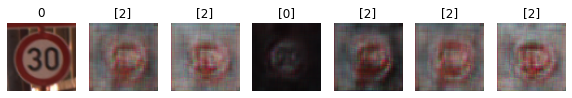

Epoch 6710 g_loss= 5.579311 d_loss= 0.0077356216 real_acc= 1.0 fake_acc= 1.0
Epoch 6720 g_loss= 4.8602037 d_loss= 0.00808039 real_acc= 1.0 fake_acc= 1.0
Epoch 6730 g_loss= 4.9969935 d_loss= 0.023615794 real_acc= 0.98 fake_acc= 1.0
Epoch 6740 g_loss= 5.8102446 d_loss= 0.010447631 real_acc= 1.0 fake_acc= 1.0
Epoch 6750 g_loss= 5.768323 d_loss= 0.028581413 real_acc= 0.98 fake_acc= 1.0
Epoch 6760 g_loss= 4.0413575 d_loss= 0.016867025 real_acc= 1.0 fake_acc= 1.0
Epoch 6770 g_loss= 4.3943543 d_loss= 0.018029043 real_acc= 1.0 fake_acc= 1.0
Epoch 6780 g_loss= 4.2180986 d_loss= 0.023718221 real_acc= 0.98 fake_acc= 1.0
Epoch 6790 g_loss= 5.3719444 d_loss= 0.007510246 real_acc= 1.0 fake_acc= 1.0
Epoch 6800 g_loss= 4.574239 d_loss= 0.015161455 real_acc= 1.0 fake_acc= 1.0


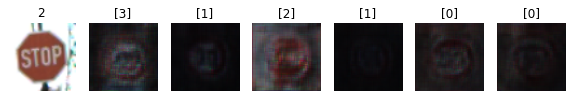

Epoch 6810 g_loss= 5.144455 d_loss= 0.010607601 real_acc= 1.0 fake_acc= 1.0
Epoch 6820 g_loss= 4.402982 d_loss= 0.0526108 real_acc= 0.94 fake_acc= 1.0
Epoch 6830 g_loss= 5.7891555 d_loss= 0.01514981 real_acc= 0.98 fake_acc= 1.0
Epoch 6840 g_loss= 4.8719893 d_loss= 0.023993252 real_acc= 1.0 fake_acc= 1.0
Epoch 6850 g_loss= 4.520271 d_loss= 0.011726229 real_acc= 1.0 fake_acc= 1.0
Epoch 6860 g_loss= 5.7410674 d_loss= 0.03952625 real_acc= 0.96 fake_acc= 1.0
Epoch 6870 g_loss= 5.777156 d_loss= 0.025621368 real_acc= 0.98 fake_acc= 1.0
Epoch 6880 g_loss= 6.3269863 d_loss= 0.023795925 real_acc= 0.98 fake_acc= 1.0
Epoch 6890 g_loss= 5.345586 d_loss= 0.012244623 real_acc= 0.98 fake_acc= 1.0
Epoch 6900 g_loss= 4.867935 d_loss= 0.014685022 real_acc= 1.0 fake_acc= 1.0


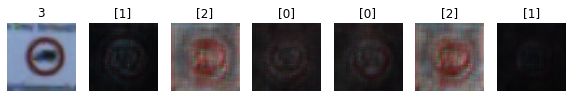

Epoch 6910 g_loss= 5.0985217 d_loss= 0.008342744 real_acc= 1.0 fake_acc= 1.0
Epoch 6920 g_loss= 5.257954 d_loss= 0.008325184 real_acc= 1.0 fake_acc= 1.0
Epoch 6930 g_loss= 4.724077 d_loss= 0.015539739 real_acc= 1.0 fake_acc= 1.0
Epoch 6940 g_loss= 5.061587 d_loss= 0.018367868 real_acc= 0.98 fake_acc= 1.0
Epoch 6950 g_loss= 5.0790825 d_loss= 0.019640896 real_acc= 0.98 fake_acc= 1.0
Epoch 6960 g_loss= 5.2889867 d_loss= 0.010848392 real_acc= 1.0 fake_acc= 1.0
Epoch 6970 g_loss= 5.136308 d_loss= 0.019166883 real_acc= 1.0 fake_acc= 1.0
Epoch 6980 g_loss= 5.0759277 d_loss= 0.010142416 real_acc= 1.0 fake_acc= 1.0
Epoch 6990 g_loss= 5.433603 d_loss= 0.017385494 real_acc= 0.98 fake_acc= 1.0
Epoch 7000 g_loss= 5.1948853 d_loss= 0.007014998 real_acc= 1.0 fake_acc= 1.0


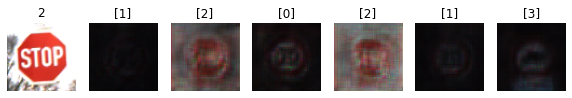

Epoch 7010 g_loss= 4.9138684 d_loss= 0.04324261 real_acc= 0.96 fake_acc= 1.0
Epoch 7020 g_loss= 5.102205 d_loss= 0.013272079 real_acc= 1.0 fake_acc= 1.0
Epoch 7030 g_loss= 5.875598 d_loss= 0.008733458 real_acc= 1.0 fake_acc= 1.0
Epoch 7040 g_loss= 5.94609 d_loss= 0.0092038885 real_acc= 1.0 fake_acc= 1.0
Epoch 7050 g_loss= 3.2775116 d_loss= 0.035070926 real_acc= 1.0 fake_acc= 1.0
Epoch 7060 g_loss= 3.647137 d_loss= 0.041681413 real_acc= 1.0 fake_acc= 1.0
Epoch 7070 g_loss= 3.5047889 d_loss= 0.027541302 real_acc= 1.0 fake_acc= 1.0
Epoch 7080 g_loss= 6.2940197 d_loss= 0.015064051 real_acc= 0.98 fake_acc= 1.0
Epoch 7090 g_loss= 5.7042847 d_loss= 0.0060802186 real_acc= 1.0 fake_acc= 1.0
Epoch 7100 g_loss= 5.577865 d_loss= 0.008664953 real_acc= 1.0 fake_acc= 1.0


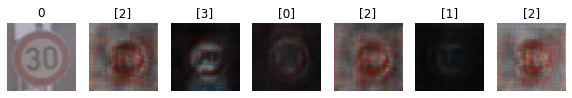

Epoch 7110 g_loss= 5.295179 d_loss= 0.009187631 real_acc= 1.0 fake_acc= 1.0
Epoch 7120 g_loss= 5.2480583 d_loss= 0.007916479 real_acc= 1.0 fake_acc= 1.0
Epoch 7130 g_loss= 6.663337 d_loss= 0.009971899 real_acc= 1.0 fake_acc= 1.0
Epoch 7140 g_loss= 4.9633675 d_loss= 0.007130467 real_acc= 1.0 fake_acc= 1.0
Epoch 7150 g_loss= 6.094703 d_loss= 0.021576425 real_acc= 0.98 fake_acc= 1.0
Epoch 7160 g_loss= 5.4648423 d_loss= 0.005207373 real_acc= 1.0 fake_acc= 1.0
Epoch 7170 g_loss= 4.9855566 d_loss= 0.010372965 real_acc= 1.0 fake_acc= 1.0
Epoch 7180 g_loss= 6.8823576 d_loss= 0.025865415 real_acc= 0.94 fake_acc= 1.0
Epoch 7190 g_loss= 5.6733155 d_loss= 0.017653257 real_acc= 0.98 fake_acc= 1.0
Epoch 7200 g_loss= 5.0693407 d_loss= 0.007560067 real_acc= 1.0 fake_acc= 1.0


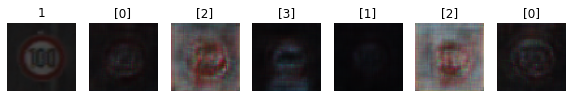

Epoch 7210 g_loss= 5.397897 d_loss= 0.006191172 real_acc= 1.0 fake_acc= 1.0
Epoch 7220 g_loss= 4.1595845 d_loss= 0.012623471 real_acc= 1.0 fake_acc= 1.0
Epoch 7230 g_loss= 5.6544147 d_loss= 0.013718704 real_acc= 1.0 fake_acc= 1.0
Epoch 7240 g_loss= 5.3791237 d_loss= 0.0074555203 real_acc= 1.0 fake_acc= 1.0
Epoch 7250 g_loss= 5.0028276 d_loss= 0.0139668435 real_acc= 0.98 fake_acc= 1.0
Epoch 7260 g_loss= 4.2087035 d_loss= 0.013221126 real_acc= 1.0 fake_acc= 1.0
Epoch 7270 g_loss= 4.992682 d_loss= 0.009659755 real_acc= 1.0 fake_acc= 1.0
Epoch 7280 g_loss= 5.793392 d_loss= 0.0083949715 real_acc= 1.0 fake_acc= 1.0
Epoch 7290 g_loss= 5.042797 d_loss= 0.02234861 real_acc= 1.0 fake_acc= 1.0
Epoch 7300 g_loss= 7.2279625 d_loss= 0.004553988 real_acc= 1.0 fake_acc= 1.0


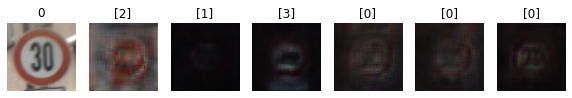

Epoch 7310 g_loss= 4.515739 d_loss= 0.033417776 real_acc= 0.96 fake_acc= 1.0
Epoch 7320 g_loss= 6.740855 d_loss= 0.012290784 real_acc= 1.0 fake_acc= 1.0
Epoch 7330 g_loss= 5.4653535 d_loss= 0.021736816 real_acc= 0.98 fake_acc= 1.0
Epoch 7340 g_loss= 5.0833354 d_loss= 0.024809033 real_acc= 0.98 fake_acc= 1.0
Epoch 7350 g_loss= 6.216184 d_loss= 0.02676207 real_acc= 0.96 fake_acc= 1.0
Epoch 7360 g_loss= 5.8544426 d_loss= 0.0045771045 real_acc= 1.0 fake_acc= 1.0
Epoch 7370 g_loss= 4.8641744 d_loss= 0.008740578 real_acc= 1.0 fake_acc= 1.0
Epoch 7380 g_loss= 4.8260846 d_loss= 0.0103200525 real_acc= 1.0 fake_acc= 1.0
Epoch 7390 g_loss= 5.109425 d_loss= 0.009167469 real_acc= 1.0 fake_acc= 1.0
Epoch 7400 g_loss= 5.72673 d_loss= 0.0034972057 real_acc= 1.0 fake_acc= 1.0


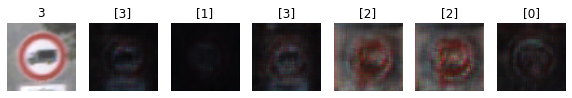

Epoch 7410 g_loss= 5.3195925 d_loss= 0.0058660996 real_acc= 1.0 fake_acc= 1.0
Epoch 7420 g_loss= 5.5346913 d_loss= 0.009706669 real_acc= 1.0 fake_acc= 1.0
Epoch 7430 g_loss= 5.773738 d_loss= 0.010317475 real_acc= 1.0 fake_acc= 1.0
Epoch 7440 g_loss= 4.78923 d_loss= 0.012088195 real_acc= 1.0 fake_acc= 1.0
Epoch 7450 g_loss= 5.9047127 d_loss= 0.0039890497 real_acc= 1.0 fake_acc= 1.0
Epoch 7460 g_loss= 5.961199 d_loss= 0.003508674 real_acc= 1.0 fake_acc= 1.0
Epoch 7470 g_loss= 4.4652033 d_loss= 0.017497452 real_acc= 1.0 fake_acc= 1.0
Epoch 7480 g_loss= 6.0250745 d_loss= 0.027129987 real_acc= 0.98 fake_acc= 1.0
Epoch 7490 g_loss= 5.4689283 d_loss= 0.0072115515 real_acc= 1.0 fake_acc= 1.0
Epoch 7500 g_loss= 4.9434276 d_loss= 0.0148626575 real_acc= 1.0 fake_acc= 1.0


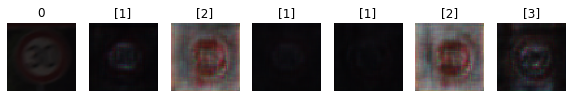

Epoch 7510 g_loss= 4.9164724 d_loss= 0.033309296 real_acc= 0.96 fake_acc= 1.0
Epoch 7520 g_loss= 6.8856335 d_loss= 0.002588842 real_acc= 1.0 fake_acc= 1.0
Epoch 7530 g_loss= 5.357586 d_loss= 0.007567481 real_acc= 1.0 fake_acc= 1.0
Epoch 7540 g_loss= 5.3523583 d_loss= 0.01310721 real_acc= 1.0 fake_acc= 1.0
Epoch 7550 g_loss= 4.594965 d_loss= 0.0083322795 real_acc= 1.0 fake_acc= 1.0
Epoch 7560 g_loss= 5.7548 d_loss= 0.005534559 real_acc= 1.0 fake_acc= 1.0
Epoch 7570 g_loss= 5.5755925 d_loss= 0.0067560025 real_acc= 1.0 fake_acc= 1.0
Epoch 7580 g_loss= 4.8569655 d_loss= 0.0071405764 real_acc= 1.0 fake_acc= 1.0
Epoch 7590 g_loss= 6.0040073 d_loss= 0.009441168 real_acc= 1.0 fake_acc= 1.0
Epoch 7600 g_loss= 7.305514 d_loss= 0.025633486 real_acc= 0.96 fake_acc= 1.0


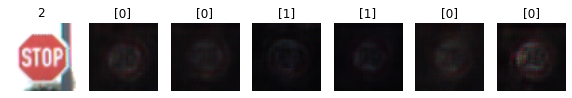

Epoch 7610 g_loss= 5.4813414 d_loss= 0.008389482 real_acc= 1.0 fake_acc= 1.0
Epoch 7620 g_loss= 5.2380714 d_loss= 0.012073098 real_acc= 1.0 fake_acc= 1.0
Epoch 7630 g_loss= 5.640824 d_loss= 0.004718737 real_acc= 1.0 fake_acc= 1.0
Epoch 7640 g_loss= 5.94918 d_loss= 0.02116871 real_acc= 0.98 fake_acc= 1.0
Epoch 7650 g_loss= 5.7678127 d_loss= 0.015301987 real_acc= 0.98 fake_acc= 1.0
Epoch 7660 g_loss= 6.6544323 d_loss= 0.017074972 real_acc= 0.98 fake_acc= 1.0
Epoch 7670 g_loss= 6.1419845 d_loss= 0.0076648938 real_acc= 1.0 fake_acc= 1.0
Epoch 7680 g_loss= 5.109964 d_loss= 0.014006113 real_acc= 1.0 fake_acc= 1.0
Epoch 7690 g_loss= 6.2962785 d_loss= 0.0030994734 real_acc= 1.0 fake_acc= 1.0
Epoch 7700 g_loss= 5.163775 d_loss= 0.005209699 real_acc= 1.0 fake_acc= 1.0


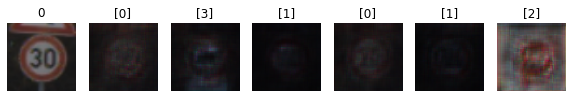

Epoch 7710 g_loss= 6.637761 d_loss= 0.021851506 real_acc= 0.98 fake_acc= 1.0
Epoch 7720 g_loss= 5.8981605 d_loss= 0.006665431 real_acc= 1.0 fake_acc= 1.0
Epoch 7730 g_loss= 4.500101 d_loss= 0.015144127 real_acc= 1.0 fake_acc= 1.0
Epoch 7740 g_loss= 5.147618 d_loss= 0.0077206222 real_acc= 1.0 fake_acc= 1.0
Epoch 7750 g_loss= 5.6901073 d_loss= 0.018038152 real_acc= 0.98 fake_acc= 1.0
Epoch 7760 g_loss= 5.283441 d_loss= 0.010509023 real_acc= 1.0 fake_acc= 1.0
Epoch 7770 g_loss= 5.579867 d_loss= 0.005538777 real_acc= 1.0 fake_acc= 1.0
Epoch 7780 g_loss= 5.3295054 d_loss= 0.008547278 real_acc= 1.0 fake_acc= 1.0
Epoch 7790 g_loss= 5.7418957 d_loss= 0.0037928873 real_acc= 1.0 fake_acc= 1.0
Epoch 7800 g_loss= 5.581461 d_loss= 0.0038829192 real_acc= 1.0 fake_acc= 1.0


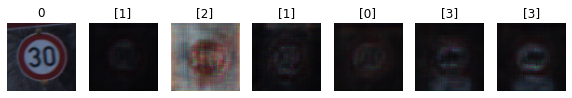

Epoch 7810 g_loss= 5.86776 d_loss= 0.017904524 real_acc= 1.0 fake_acc= 1.0
Epoch 7820 g_loss= 4.388824 d_loss= 0.011969903 real_acc= 1.0 fake_acc= 1.0
Epoch 7830 g_loss= 4.0418377 d_loss= 0.02123437 real_acc= 1.0 fake_acc= 1.0
Epoch 7840 g_loss= 6.0673566 d_loss= 0.007036518 real_acc= 1.0 fake_acc= 1.0
Epoch 7850 g_loss= 6.1525893 d_loss= 0.0035228047 real_acc= 1.0 fake_acc= 1.0
Epoch 7860 g_loss= 5.1971498 d_loss= 0.023458436 real_acc= 0.98 fake_acc= 1.0
Epoch 7870 g_loss= 5.267615 d_loss= 0.011348023 real_acc= 1.0 fake_acc= 1.0
Epoch 7880 g_loss= 6.8240137 d_loss= 0.003341284 real_acc= 1.0 fake_acc= 1.0
Epoch 7890 g_loss= 4.733887 d_loss= 0.011086951 real_acc= 1.0 fake_acc= 1.0
Epoch 7900 g_loss= 5.1444335 d_loss= 0.009253978 real_acc= 1.0 fake_acc= 1.0


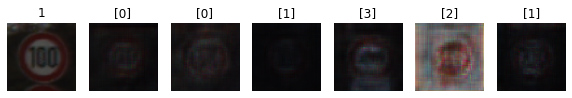

Epoch 7910 g_loss= 6.4155912 d_loss= 0.0031250939 real_acc= 1.0 fake_acc= 1.0
Epoch 7920 g_loss= 5.4520597 d_loss= 0.01026779 real_acc= 1.0 fake_acc= 1.0
Epoch 7930 g_loss= 5.4687524 d_loss= 0.0067814523 real_acc= 1.0 fake_acc= 1.0
Epoch 7940 g_loss= 5.298652 d_loss= 0.005206054 real_acc= 1.0 fake_acc= 1.0
Epoch 7950 g_loss= 5.855151 d_loss= 0.009320933 real_acc= 1.0 fake_acc= 1.0
Epoch 7960 g_loss= 6.2236977 d_loss= 0.0057800496 real_acc= 1.0 fake_acc= 1.0
Epoch 7970 g_loss= 5.5145006 d_loss= 0.011091327 real_acc= 1.0 fake_acc= 1.0
Epoch 7980 g_loss= 4.962404 d_loss= 0.005488372 real_acc= 1.0 fake_acc= 1.0
Epoch 7990 g_loss= 6.4300694 d_loss= 0.012720336 real_acc= 0.98 fake_acc= 1.0
Epoch 8000 g_loss= 6.6458106 d_loss= 0.01523357 real_acc= 0.98 fake_acc= 1.0


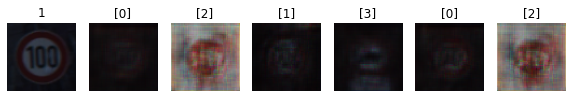

Epoch 8010 g_loss= 5.884939 d_loss= 0.007998887 real_acc= 1.0 fake_acc= 1.0
Epoch 8020 g_loss= 6.5893946 d_loss= 0.008828793 real_acc= 1.0 fake_acc= 1.0
Epoch 8030 g_loss= 6.52139 d_loss= 0.0057880273 real_acc= 1.0 fake_acc= 1.0
Epoch 8040 g_loss= 5.637432 d_loss= 0.003820966 real_acc= 1.0 fake_acc= 1.0
Epoch 8050 g_loss= 6.0193496 d_loss= 0.0023800014 real_acc= 1.0 fake_acc= 1.0
Epoch 8060 g_loss= 5.6527214 d_loss= 0.005072096 real_acc= 1.0 fake_acc= 1.0
Epoch 8070 g_loss= 5.621661 d_loss= 0.009471824 real_acc= 1.0 fake_acc= 1.0
Epoch 8080 g_loss= 5.9046397 d_loss= 0.0055232276 real_acc= 1.0 fake_acc= 1.0
Epoch 8090 g_loss= 6.284259 d_loss= 0.008336237 real_acc= 1.0 fake_acc= 1.0
Epoch 8100 g_loss= 7.187441 d_loss= 0.022286464 real_acc= 0.98 fake_acc= 1.0


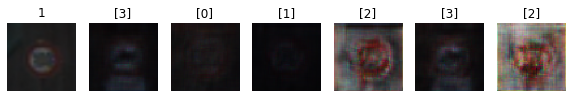

Epoch 8110 g_loss= 6.8644977 d_loss= 0.012011992 real_acc= 0.98 fake_acc= 1.0
Epoch 8120 g_loss= 4.9584384 d_loss= 0.0067628464 real_acc= 1.0 fake_acc= 1.0
Epoch 8130 g_loss= 6.1340575 d_loss= 0.024162367 real_acc= 0.98 fake_acc= 1.0
Epoch 8140 g_loss= 7.4563713 d_loss= 0.004473198 real_acc= 1.0 fake_acc= 1.0
Epoch 8150 g_loss= 5.3359404 d_loss= 0.008928061 real_acc= 1.0 fake_acc= 1.0
Epoch 8160 g_loss= 6.4943333 d_loss= 0.013594598 real_acc= 0.98 fake_acc= 1.0
Epoch 8170 g_loss= 6.302527 d_loss= 0.0030018492 real_acc= 1.0 fake_acc= 1.0
Epoch 8180 g_loss= 6.3955464 d_loss= 0.0063397884 real_acc= 1.0 fake_acc= 1.0
Epoch 8190 g_loss= 6.88026 d_loss= 0.0014915512 real_acc= 1.0 fake_acc= 1.0
Epoch 8200 g_loss= 4.3931203 d_loss= 0.010457518 real_acc= 1.0 fake_acc= 1.0


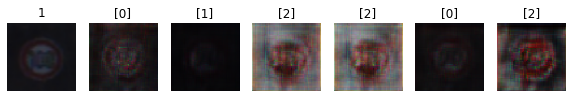

Epoch 8210 g_loss= 5.306024 d_loss= 0.005225892 real_acc= 1.0 fake_acc= 1.0
Epoch 8220 g_loss= 6.1157665 d_loss= 0.0075664213 real_acc= 1.0 fake_acc= 1.0
Epoch 8230 g_loss= 6.5834913 d_loss= 0.00725649 real_acc= 1.0 fake_acc= 1.0
Epoch 8240 g_loss= 6.1729383 d_loss= 0.0075887293 real_acc= 1.0 fake_acc= 1.0
Epoch 8250 g_loss= 6.365441 d_loss= 0.0044959546 real_acc= 1.0 fake_acc= 1.0
Epoch 8260 g_loss= 3.9041119 d_loss= 0.02525244 real_acc= 1.0 fake_acc= 1.0
Epoch 8270 g_loss= 3.6866677 d_loss= 0.020129217 real_acc= 1.0 fake_acc= 1.0
Epoch 8280 g_loss= 7.3101864 d_loss= 0.022258027 real_acc= 0.98 fake_acc= 1.0
Epoch 8290 g_loss= 7.2165165 d_loss= 0.0013469179 real_acc= 1.0 fake_acc= 1.0
Epoch 8300 g_loss= 5.7345595 d_loss= 0.009066326 real_acc= 1.0 fake_acc= 1.0


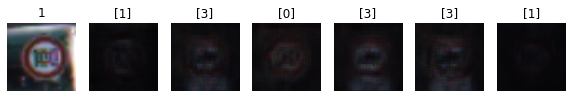

Epoch 8310 g_loss= 3.9297204 d_loss= 0.015329495 real_acc= 1.0 fake_acc= 1.0
Epoch 8320 g_loss= 7.1097493 d_loss= 0.01652283 real_acc= 0.96 fake_acc= 1.0
Epoch 8330 g_loss= 6.149324 d_loss= 0.00510333 real_acc= 1.0 fake_acc= 1.0
Epoch 8340 g_loss= 7.314328 d_loss= 0.0051798495 real_acc= 1.0 fake_acc= 1.0
Epoch 8350 g_loss= 5.3415895 d_loss= 0.007920232 real_acc= 1.0 fake_acc= 1.0
Epoch 8360 g_loss= 5.0249767 d_loss= 0.0065647895 real_acc= 1.0 fake_acc= 1.0
Epoch 8370 g_loss= 7.685709 d_loss= 0.0013754976 real_acc= 1.0 fake_acc= 1.0
Epoch 8380 g_loss= 6.5909896 d_loss= 0.011734081 real_acc= 1.0 fake_acc= 1.0
Epoch 8390 g_loss= 6.65223 d_loss= 0.018764807 real_acc= 0.98 fake_acc= 1.0
Epoch 8400 g_loss= 3.7451587 d_loss= 0.020320078 real_acc= 1.0 fake_acc= 1.0


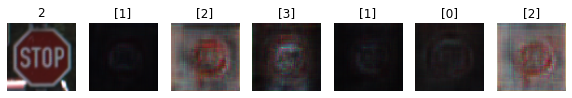

Epoch 8410 g_loss= 5.926186 d_loss= 0.009370746 real_acc= 1.0 fake_acc= 1.0
Epoch 8420 g_loss= 7.4282994 d_loss= 0.0016779059 real_acc= 1.0 fake_acc= 1.0
Epoch 8430 g_loss= 5.9102983 d_loss= 0.0043382267 real_acc= 1.0 fake_acc= 1.0
Epoch 8440 g_loss= 5.550642 d_loss= 0.013598326 real_acc= 0.98 fake_acc= 1.0
Epoch 8450 g_loss= 6.1261907 d_loss= 0.0057210624 real_acc= 1.0 fake_acc= 1.0
Epoch 8460 g_loss= 5.544763 d_loss= 0.006146477 real_acc= 1.0 fake_acc= 1.0
Epoch 8470 g_loss= 8.983303 d_loss= 0.04213469 real_acc= 0.96 fake_acc= 1.0
Epoch 8480 g_loss= 7.2469387 d_loss= 0.008913829 real_acc= 0.98 fake_acc= 1.0
Epoch 8490 g_loss= 7.3886976 d_loss= 0.00538593 real_acc= 1.0 fake_acc= 1.0
Epoch 8500 g_loss= 8.794845 d_loss= 0.007306493 real_acc= 1.0 fake_acc= 1.0


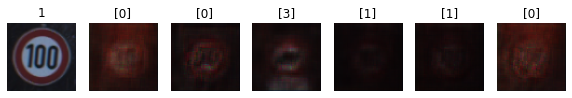

Epoch 8510 g_loss= 5.484514 d_loss= 0.010658165 real_acc= 1.0 fake_acc= 1.0
Epoch 8520 g_loss= 7.1611023 d_loss= 0.022039426 real_acc= 0.96 fake_acc= 1.0
Epoch 8530 g_loss= 7.181747 d_loss= 0.011393831 real_acc= 1.0 fake_acc= 1.0
Epoch 8540 g_loss= 8.212599 d_loss= 0.0033331465 real_acc= 1.0 fake_acc= 1.0
Epoch 8550 g_loss= 7.55476 d_loss= 0.0052948324 real_acc= 1.0 fake_acc= 1.0
Epoch 8560 g_loss= 6.146605 d_loss= 0.027064376 real_acc= 0.98 fake_acc= 1.0
Epoch 8570 g_loss= 8.393235 d_loss= 0.004179032 real_acc= 1.0 fake_acc= 1.0
Epoch 8580 g_loss= 5.1291804 d_loss= 0.007009398 real_acc= 1.0 fake_acc= 1.0
Epoch 8590 g_loss= 6.6864305 d_loss= 0.0054689357 real_acc= 1.0 fake_acc= 1.0
Epoch 8600 g_loss= 6.093998 d_loss= 0.0060520284 real_acc= 1.0 fake_acc= 1.0


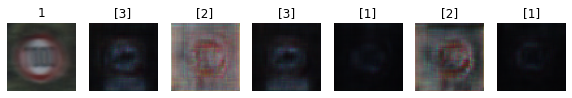

Epoch 8610 g_loss= 5.2086115 d_loss= 0.0070630694 real_acc= 1.0 fake_acc= 1.0
Epoch 8620 g_loss= 6.533801 d_loss= 0.012497993 real_acc= 0.98 fake_acc= 1.0
Epoch 8630 g_loss= 7.9378114 d_loss= 0.0064250026 real_acc= 1.0 fake_acc= 1.0
Epoch 8640 g_loss= 6.7788873 d_loss= 0.004356131 real_acc= 1.0 fake_acc= 1.0
Epoch 8650 g_loss= 4.241555 d_loss= 0.013092644 real_acc= 1.0 fake_acc= 1.0
Epoch 8660 g_loss= 5.6015205 d_loss= 0.005728527 real_acc= 1.0 fake_acc= 1.0
Epoch 8670 g_loss= 7.654974 d_loss= 0.0025944258 real_acc= 1.0 fake_acc= 1.0
Epoch 8680 g_loss= 6.1404943 d_loss= 0.0049939747 real_acc= 1.0 fake_acc= 1.0
Epoch 8690 g_loss= 6.3564343 d_loss= 0.00501745 real_acc= 1.0 fake_acc= 1.0
Epoch 8700 g_loss= 9.1895 d_loss= 0.0034101172 real_acc= 1.0 fake_acc= 1.0


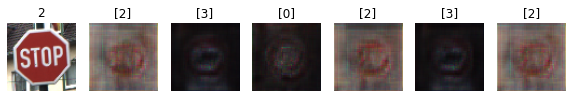

Epoch 8710 g_loss= 4.874907 d_loss= 0.008751707 real_acc= 1.0 fake_acc= 1.0
Epoch 8720 g_loss= 6.6781898 d_loss= 0.0045895665 real_acc= 1.0 fake_acc= 1.0
Epoch 8730 g_loss= 7.5368886 d_loss= 0.010233727 real_acc= 0.98 fake_acc= 1.0
Epoch 8740 g_loss= 5.442202 d_loss= 0.007422436 real_acc= 1.0 fake_acc= 1.0
Epoch 8750 g_loss= 5.788354 d_loss= 0.00818572 real_acc= 1.0 fake_acc= 1.0
Epoch 8760 g_loss= 6.4090505 d_loss= 0.0039980854 real_acc= 1.0 fake_acc= 1.0
Epoch 8770 g_loss= 6.203039 d_loss= 0.006835567 real_acc= 1.0 fake_acc= 1.0
Epoch 8780 g_loss= 5.9883995 d_loss= 0.0048506446 real_acc= 1.0 fake_acc= 1.0
Epoch 8790 g_loss= 7.1546373 d_loss= 0.0020671233 real_acc= 1.0 fake_acc= 1.0
Epoch 8800 g_loss= 6.782954 d_loss= 0.0041235024 real_acc= 1.0 fake_acc= 1.0


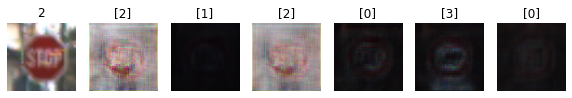

Epoch 8810 g_loss= 6.814998 d_loss= 0.0054908413 real_acc= 1.0 fake_acc= 1.0
Epoch 8820 g_loss= 4.5617394 d_loss= 0.010988686 real_acc= 1.0 fake_acc= 1.0
Epoch 8830 g_loss= 7.277845 d_loss= 0.0020296136 real_acc= 1.0 fake_acc= 1.0
Epoch 8840 g_loss= 6.7107763 d_loss= 0.00400858 real_acc= 1.0 fake_acc= 1.0
Epoch 8850 g_loss= 7.8962164 d_loss= 0.0012672704 real_acc= 1.0 fake_acc= 1.0
Epoch 8860 g_loss= 5.5085583 d_loss= 0.018312395 real_acc= 0.98 fake_acc= 1.0
Epoch 8870 g_loss= 6.136099 d_loss= 0.0077532157 real_acc= 1.0 fake_acc= 1.0
Epoch 8880 g_loss= 6.205305 d_loss= 0.017891614 real_acc= 0.98 fake_acc= 1.0
Epoch 8890 g_loss= 7.232191 d_loss= 0.0017779696 real_acc= 1.0 fake_acc= 1.0
Epoch 8900 g_loss= 6.6576595 d_loss= 0.002811376 real_acc= 1.0 fake_acc= 1.0


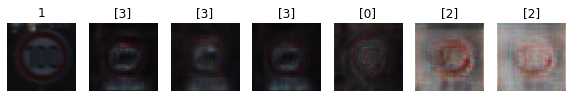

Epoch 8910 g_loss= 6.8286757 d_loss= 0.005724795 real_acc= 1.0 fake_acc= 1.0
Epoch 8920 g_loss= 6.6170335 d_loss= 0.003125734 real_acc= 1.0 fake_acc= 1.0
Epoch 8930 g_loss= 6.584944 d_loss= 0.0056793815 real_acc= 1.0 fake_acc= 1.0
Epoch 8940 g_loss= 6.5433497 d_loss= 0.0023448823 real_acc= 1.0 fake_acc= 1.0
Epoch 8950 g_loss= 6.6897707 d_loss= 0.002926398 real_acc= 1.0 fake_acc= 1.0
Epoch 8960 g_loss= 7.7503786 d_loss= 0.00087135634 real_acc= 1.0 fake_acc= 1.0
Epoch 8970 g_loss= 5.9436407 d_loss= 0.005274357 real_acc= 1.0 fake_acc= 1.0
Epoch 8980 g_loss= 7.9641323 d_loss= 0.013106085 real_acc= 0.98 fake_acc= 1.0
Epoch 8990 g_loss= 7.2361946 d_loss= 0.0019046606 real_acc= 1.0 fake_acc= 1.0
Epoch 9000 g_loss= 6.0025783 d_loss= 0.0049787248 real_acc= 1.0 fake_acc= 1.0


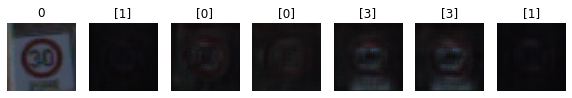

Epoch 9010 g_loss= 8.680791 d_loss= 0.0047216406 real_acc= 1.0 fake_acc= 1.0
Epoch 9020 g_loss= 5.465768 d_loss= 0.0054404777 real_acc= 1.0 fake_acc= 1.0
Epoch 9030 g_loss= 7.2262635 d_loss= 0.0021270954 real_acc= 1.0 fake_acc= 1.0
Epoch 9040 g_loss= 6.9807777 d_loss= 0.014013558 real_acc= 0.98 fake_acc= 1.0
Epoch 9050 g_loss= 6.8876977 d_loss= 0.0019075649 real_acc= 1.0 fake_acc= 1.0
Epoch 9060 g_loss= 6.2032456 d_loss= 0.0176372 real_acc= 0.98 fake_acc= 1.0
Epoch 9070 g_loss= 6.358536 d_loss= 0.0032597512 real_acc= 1.0 fake_acc= 1.0
Epoch 9080 g_loss= 7.487483 d_loss= 0.020293316 real_acc= 0.98 fake_acc= 1.0
Epoch 9090 g_loss= 7.797919 d_loss= 0.0035411152 real_acc= 1.0 fake_acc= 1.0
Epoch 9100 g_loss= 5.8252807 d_loss= 0.0042451825 real_acc= 1.0 fake_acc= 1.0


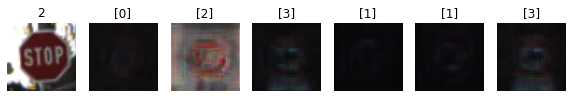

Epoch 9110 g_loss= 6.776221 d_loss= 0.006555939 real_acc= 1.0 fake_acc= 1.0
Epoch 9120 g_loss= 5.2836375 d_loss= 0.0064028697 real_acc= 1.0 fake_acc= 1.0
Epoch 9130 g_loss= 8.301525 d_loss= 0.0012798747 real_acc= 1.0 fake_acc= 1.0
Epoch 9140 g_loss= 8.6471615 d_loss= 0.002732608 real_acc= 1.0 fake_acc= 1.0
Epoch 9150 g_loss= 5.2035933 d_loss= 0.008836754 real_acc= 1.0 fake_acc= 1.0
Epoch 9160 g_loss= 8.567207 d_loss= 0.0050424254 real_acc= 1.0 fake_acc= 1.0
Epoch 9170 g_loss= 8.077158 d_loss= 0.0012459606 real_acc= 1.0 fake_acc= 1.0
Epoch 9180 g_loss= 4.7920766 d_loss= 0.0072870036 real_acc= 1.0 fake_acc= 1.0
Epoch 9190 g_loss= 7.063213 d_loss= 0.0051721334 real_acc= 1.0 fake_acc= 1.0
Epoch 9200 g_loss= 6.5237885 d_loss= 0.003448251 real_acc= 1.0 fake_acc= 1.0


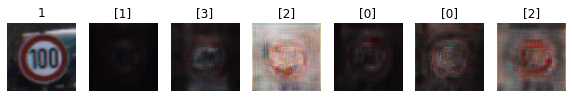

Epoch 9210 g_loss= 6.769231 d_loss= 0.003661728 real_acc= 1.0 fake_acc= 1.0
Epoch 9220 g_loss= 6.5851917 d_loss= 0.0033900712 real_acc= 1.0 fake_acc= 1.0
Epoch 9230 g_loss= 6.2761297 d_loss= 0.0038440314 real_acc= 1.0 fake_acc= 1.0
Epoch 9240 g_loss= 4.924462 d_loss= 0.0069644693 real_acc= 1.0 fake_acc= 1.0
Epoch 9250 g_loss= 8.362397 d_loss= 0.0009276081 real_acc= 1.0 fake_acc= 1.0
Epoch 9260 g_loss= 7.153083 d_loss= 0.017079301 real_acc= 0.98 fake_acc= 1.0
Epoch 9270 g_loss= 7.5573473 d_loss= 0.00536046 real_acc= 1.0 fake_acc= 1.0
Epoch 9280 g_loss= 5.5387096 d_loss= 0.006994113 real_acc= 1.0 fake_acc= 1.0
Epoch 9290 g_loss= 7.448957 d_loss= 0.00083092414 real_acc= 1.0 fake_acc= 1.0
Epoch 9300 g_loss= 6.8526173 d_loss= 0.0045169983 real_acc= 1.0 fake_acc= 1.0


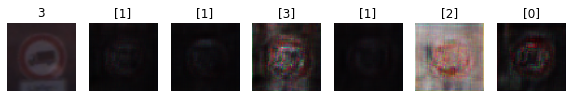

Epoch 9310 g_loss= 9.896179 d_loss= 0.00040149927 real_acc= 1.0 fake_acc= 1.0
Epoch 9320 g_loss= 5.8803325 d_loss= 0.004390611 real_acc= 1.0 fake_acc= 1.0
Epoch 9330 g_loss= 7.8584766 d_loss= 0.00071528787 real_acc= 1.0 fake_acc= 1.0
Epoch 9340 g_loss= 5.2344813 d_loss= 0.0062241564 real_acc= 1.0 fake_acc= 1.0
Epoch 9350 g_loss= 9.09405 d_loss= 0.0011257909 real_acc= 1.0 fake_acc= 1.0
Epoch 9360 g_loss= 5.778637 d_loss= 0.004881893 real_acc= 1.0 fake_acc= 1.0
Epoch 9370 g_loss= 6.399591 d_loss= 0.0024701282 real_acc= 1.0 fake_acc= 1.0
Epoch 9380 g_loss= 8.0140505 d_loss= 0.0014484387 real_acc= 1.0 fake_acc= 1.0
Epoch 9390 g_loss= 6.5558205 d_loss= 0.0040169996 real_acc= 1.0 fake_acc= 1.0
Epoch 9400 g_loss= 6.5038366 d_loss= 0.014087121 real_acc= 0.98 fake_acc= 1.0


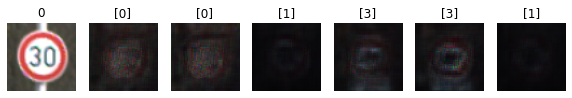

Epoch 9410 g_loss= 6.0685353 d_loss= 0.007007161 real_acc= 1.0 fake_acc= 1.0
Epoch 9420 g_loss= 8.364402 d_loss= 0.0050178724 real_acc= 1.0 fake_acc= 1.0
Epoch 9430 g_loss= 6.4301033 d_loss= 0.0046449522 real_acc= 1.0 fake_acc= 1.0
Epoch 9440 g_loss= 8.015205 d_loss= 0.0019255409 real_acc= 1.0 fake_acc= 1.0
Epoch 9450 g_loss= 6.1025267 d_loss= 0.004719649 real_acc= 1.0 fake_acc= 1.0
Epoch 9460 g_loss= 7.766336 d_loss= 0.0059614647 real_acc= 1.0 fake_acc= 1.0
Epoch 9470 g_loss= 8.735446 d_loss= 0.009293446 real_acc= 1.0 fake_acc= 1.0
Epoch 9480 g_loss= 8.989353 d_loss= 0.0019429908 real_acc= 1.0 fake_acc= 1.0
Epoch 9490 g_loss= 5.2014265 d_loss= 0.007962824 real_acc= 1.0 fake_acc= 1.0
Epoch 9500 g_loss= 4.4961157 d_loss= 0.014833577 real_acc= 1.0 fake_acc= 1.0


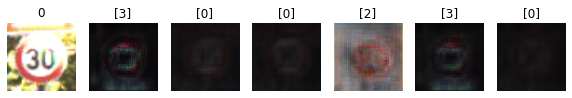

Epoch 9510 g_loss= 7.909276 d_loss= 0.007492115 real_acc= 1.0 fake_acc= 1.0
Epoch 9520 g_loss= 7.890144 d_loss= 0.00087605027 real_acc= 1.0 fake_acc= 1.0
Epoch 9530 g_loss= 10.244036 d_loss= 0.0024943086 real_acc= 1.0 fake_acc= 1.0
Epoch 9540 g_loss= 8.365239 d_loss= 0.021881025 real_acc= 0.96 fake_acc= 1.0
Epoch 9550 g_loss= 6.9897075 d_loss= 0.0050070076 real_acc= 1.0 fake_acc= 1.0
Epoch 9560 g_loss= 10.078106 d_loss= 0.03135573 real_acc= 0.98 fake_acc= 1.0
Epoch 9570 g_loss= 5.1018324 d_loss= 0.006677669 real_acc= 1.0 fake_acc= 1.0
Epoch 9580 g_loss= 5.864142 d_loss= 0.007350344 real_acc= 1.0 fake_acc= 1.0
Epoch 9590 g_loss= 7.1871963 d_loss= 0.0073426664 real_acc= 1.0 fake_acc= 1.0
Epoch 9600 g_loss= 6.3424854 d_loss= 0.0045291646 real_acc= 1.0 fake_acc= 1.0


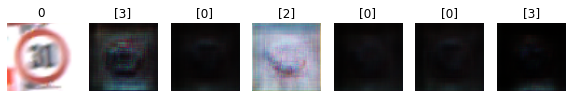

Epoch 9610 g_loss= 7.5630407 d_loss= 0.0017627955 real_acc= 1.0 fake_acc= 1.0
Epoch 9620 g_loss= 6.2358885 d_loss= 0.0033481042 real_acc= 1.0 fake_acc= 1.0
Epoch 9630 g_loss= 6.585957 d_loss= 0.0023204742 real_acc= 1.0 fake_acc= 1.0
Epoch 9640 g_loss= 6.8396044 d_loss= 0.001410554 real_acc= 1.0 fake_acc= 1.0
Epoch 9650 g_loss= 8.859091 d_loss= 0.00072553573 real_acc= 1.0 fake_acc= 1.0
Epoch 9660 g_loss= 8.097275 d_loss= 0.0026202619 real_acc= 1.0 fake_acc= 1.0
Epoch 9670 g_loss= 6.6621413 d_loss= 0.0011864649 real_acc= 1.0 fake_acc= 1.0
Epoch 9680 g_loss= 5.5062904 d_loss= 0.00381919 real_acc= 1.0 fake_acc= 1.0
Epoch 9690 g_loss= 7.8882823 d_loss= 0.0010124319 real_acc= 1.0 fake_acc= 1.0
Epoch 9700 g_loss= 4.470461 d_loss= 0.015327747 real_acc= 1.0 fake_acc= 1.0


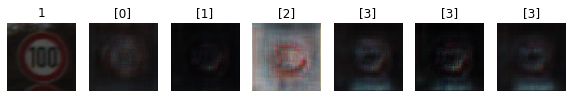

Epoch 9710 g_loss= 10.0371065 d_loss= 0.0022368634 real_acc= 1.0 fake_acc= 1.0
Epoch 9720 g_loss= 6.8424196 d_loss= 0.0034996367 real_acc= 1.0 fake_acc= 1.0
Epoch 9730 g_loss= 9.639453 d_loss= 0.0026285541 real_acc= 1.0 fake_acc= 1.0
Epoch 9740 g_loss= 6.384268 d_loss= 0.006012302 real_acc= 1.0 fake_acc= 1.0
Epoch 9750 g_loss= 6.5879335 d_loss= 0.005924221 real_acc= 1.0 fake_acc= 1.0
Epoch 9760 g_loss= 7.5805006 d_loss= 0.005153609 real_acc= 1.0 fake_acc= 1.0
Epoch 9770 g_loss= 6.4741273 d_loss= 0.0035066698 real_acc= 1.0 fake_acc= 1.0
Epoch 9780 g_loss= 8.427564 d_loss= 0.016005583 real_acc= 0.98 fake_acc= 1.0
Epoch 9790 g_loss= 7.470111 d_loss= 0.004475622 real_acc= 1.0 fake_acc= 1.0
Epoch 9800 g_loss= 7.244286 d_loss= 0.002466666 real_acc= 1.0 fake_acc= 1.0


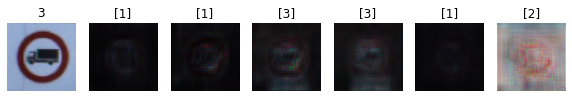

Epoch 9810 g_loss= 5.8788295 d_loss= 0.005005829 real_acc= 1.0 fake_acc= 1.0
Epoch 9820 g_loss= 9.05473 d_loss= 0.010497222 real_acc= 0.98 fake_acc= 1.0
Epoch 9830 g_loss= 5.2270107 d_loss= 0.004918921 real_acc= 1.0 fake_acc= 1.0
Epoch 9840 g_loss= 8.035752 d_loss= 0.0012921536 real_acc= 1.0 fake_acc= 1.0
Epoch 9850 g_loss= 6.5423427 d_loss= 0.004660472 real_acc= 1.0 fake_acc= 1.0
Epoch 9860 g_loss= 5.7541447 d_loss= 0.0048566866 real_acc= 1.0 fake_acc= 1.0
Epoch 9870 g_loss= 6.5458922 d_loss= 0.0024891251 real_acc= 1.0 fake_acc= 1.0
Epoch 9880 g_loss= 9.012696 d_loss= 0.00239882 real_acc= 1.0 fake_acc= 1.0
Epoch 9890 g_loss= 7.2976403 d_loss= 0.0031739143 real_acc= 1.0 fake_acc= 1.0
Epoch 9900 g_loss= 9.119343 d_loss= 0.00085468806 real_acc= 1.0 fake_acc= 1.0


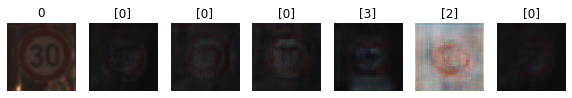

Epoch 9910 g_loss= 5.022109 d_loss= 0.009222517 real_acc= 1.0 fake_acc= 1.0
Epoch 9920 g_loss= 10.48971 d_loss= 0.0045136632 real_acc= 1.0 fake_acc= 1.0
Epoch 9930 g_loss= 4.250622 d_loss= 0.017096976 real_acc= 1.0 fake_acc= 1.0
Epoch 9940 g_loss= 9.493763 d_loss= 0.018087592 real_acc= 0.98 fake_acc= 1.0
Epoch 9950 g_loss= 9.287563 d_loss= 0.0044894656 real_acc= 1.0 fake_acc= 1.0
Epoch 9960 g_loss= 4.7987285 d_loss= 0.019382915 real_acc= 1.0 fake_acc= 1.0
Epoch 9970 g_loss= 5.4511614 d_loss= 0.008900306 real_acc= 1.0 fake_acc= 1.0
Epoch 9980 g_loss= 10.056414 d_loss= 0.012801576 real_acc= 0.98 fake_acc= 1.0
Epoch 9990 g_loss= 6.06909 d_loss= 0.0048745256 real_acc= 1.0 fake_acc= 1.0
Done


In [11]:
epochs = 10000
history = []
for epoch in range(epochs):
    # take some random samples
    new_samples,new_labels = sample_from_dataset(50,samples)
    # perform one training step (epoch)
    do_step(new_samples, new_labels)
    
    if epoch % 100 == 0:
        # show one real image and some fake images generated by generator using noise seed
        num_examples_to_generate = 6
        seed = tf.random.normal([num_examples_to_generate, noise_dim])
        random_labels = np.random.randint(4, size=num_examples_to_generate)
        random_labels = np.expand_dims(random_labels,axis=1)
        predictions = generator([seed,random_labels], training=False)
        fig = plt.figure(figsize=(10,10))
        r = random.randrange(len(samples))
        plt.subplot(1, num_examples_to_generate+1, 1)
        plt.imshow(samples[r, :, :])
        plt.title(labels[r])
        plt.axis('off')
        for i in range(predictions.shape[0]):
            plt.subplot(1, num_examples_to_generate+1, i+2)
            #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.imshow(predictions[i, :, :])
            plt.title("{}".format(random_labels[i]))
            plt.axis('off')
        plt.show()    
print("Done")

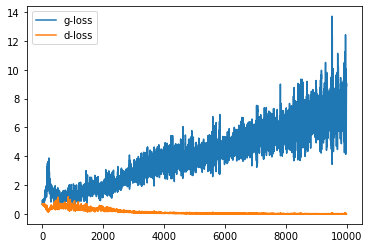

In [12]:
nph = np.array(history)

plt.plot(nph[:,0], label='g-loss')
plt.plot(nph[:,1], label='d-loss')
plt.legend()
plt.show()

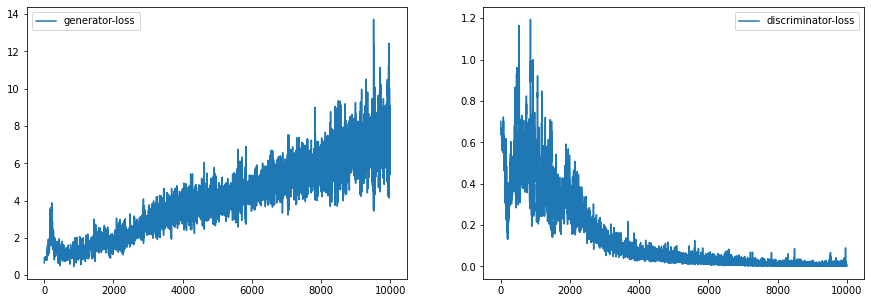

In [13]:
nph = np.array(history)
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(nph[:,0], label='generator-loss')
plt.legend()
ax = plt.subplot(1, 2, 2)
plt.plot(nph[:,1], label='discriminator-loss')
plt.legend()
plt.show()

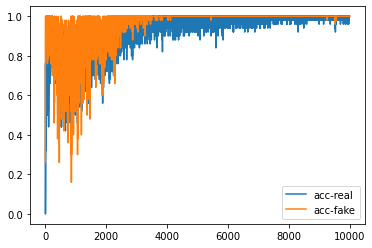

In [14]:
nph = np.array(history)

plt.plot(nph[:,2], label='acc-real')
plt.plot(nph[:,3], label='acc-fake')
plt.legend()
plt.show()

In [15]:
generator.save_weights('generator2_6000_weights')